In [1]:
# extract_accel_data.py
from datetime import datetime
import csv

filename = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025.log"

timestamps, t_values, x_values, y_values, z_values = [], [], [], [], []

with open(filename, 'r') as file:
    for line in file:
        if all(k in line for k in ['t:', 'x:', 'y:', 'z:']):
            # Extract timestamp
            if '[' in line and ']' in line:
                timestamps.append(line.split('[')[1].split(']')[0])
            
            # Extract sensor values
            parts = line.split()
            t=x=y=z=None
            for p in parts:
                if p.startswith('t:'): t=int(p[2:])
                elif p.startswith('x:'): x=int(p[2:])
                elif p.startswith('y:'): y=int(p[2:])
                elif p.startswith('z:'): z=int(p[2:])
            if None not in (t,x,y,z):
                t_values.append(t)
                x_values.append(x)
                y_values.append(y)
                z_values.append(z)

# Save CSV
csv_file = filename.replace('.log','_accelerometer.csv')
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['timestamp','t','x','y','z'])
    writer.writerows(zip(timestamps,t_values,x_values,y_values,z_values))

print(f"Data saved to {csv_file}")


Data saved to C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_accelerometer.csv


<h1>Process Accelerometer Signals

In [2]:
import math
import csv
from collections import deque
from datetime import datetime
import numpy as np
from scipy.signal import savgol_filter, find_peaks

filename = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025.log"   

def moving_average(data, window_size):
    """Calcola media mobile con finestra specificata"""
    if len(data) < window_size:
        return [sum(data) / len(data)] * len(data)
    
    result = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        result.append(sum(data[start:end]) / (end - start))
    return result

def calculate_pitch_roll(x, y, z):
    """Calcola pitch e roll dall'accelerometro"""
    # Pitch: rotazione attorno asse X
    pitch = math.atan2(y, math.sqrt(x*x + z*z)) * 180 / math.pi
    
    # Roll: rotazione attorno asse Y  
    roll = math.atan2(-x, math.sqrt(y*y + z*z)) * 180 / math.pi
    
    return pitch, roll

def detect_peaks_simple(signal, prominence=0.1):
    """Peak detection semplificato"""
    peaks = []
    for i in range(1, len(signal) - 1):
        if (signal[i] > signal[i-1] and 
            signal[i] > signal[i+1] and 
            signal[i] > prominence):
            peaks.append(i)
    return peaks

# Estrai dati base
raw_data = []
timestamps = []

with open(filename, 'r') as file:
    for line in file:
        if 't:' in line and 'x:' in line:
            # Estrai timestamp
            if '[' in line and ']' in line:
                timestamp_str = line.split('[')[1].split(']')[0]
                timestamps.append(timestamp_str)
            
            # Estrai valori accelerometro
            line_parts = line.split()
            t = x = y = z = None
            
            for part in line_parts:
                if part.startswith('t:'):
                    t = int(part[2:])
                elif part.startswith('x:'):
                    x = int(part[2:])
                elif part.startswith('y:'):
                    y = int(part[2:])
                elif part.startswith('z:'):
                    z = int(part[2:])
            
            if all(v is not None for v in [t, x, y, z]):
                raw_data.append([t, x, y, z])

if not raw_data:
    print("Nessun dato trovato!")
    exit()

print(f"Estratti {len(raw_data)} campioni")

# Separa i dati per i calcoli
t_values = [row[0] for row in raw_data]
x_values = [row[1] for row in raw_data]
y_values = [row[2] for row in raw_data]
z_values = [row[3] for row in raw_data]

# Calcola norm per ogni campione
norm_values = []
for x, y, z in zip(x_values, y_values, z_values):
    norm = math.sqrt(x*x + y*y + z*z)
    norm_values.append(norm)

# Calcola tempo in ms e secondi (stimato)
if len(timestamps) > 0:
    # Usa timestamp reali se disponibili
    start_time = datetime.strptime(timestamps[0], '%Y-%m-%d %H:%M:%S.%f')
    time_ms = []
    time_s = []
    
    for timestamp_str in timestamps:
        current_time = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S.%f')
        elapsed_ms = (current_time - start_time).total_seconds() * 1000
        time_ms.append(elapsed_ms)
        time_s.append(elapsed_ms / 1000)
else:
    # Stima tempo assumendo sampling rate costante
    time_ms = [i * 10 for i in range(len(raw_data))]  # 100Hz stimato
    time_s = [ms / 1000 for ms in time_ms]

# Calcola medie mobili (finestra 30 punti)
window_size = 30
x_mavg = moving_average(x_values, window_size)
y_mavg = moving_average(y_values, window_size)
z_mavg = moving_average(z_values, window_size)
norm_mavg = moving_average(norm_values, window_size)

# Calcola pitch e roll
pitch_values = []
roll_values = []
for x, y, z in zip(x_values, y_values, z_values):
    pitch, roll = calculate_pitch_roll(x, y, z)
    pitch_values.append(pitch)
    roll_values.append(roll)

# Savitzky-Golay filter (se hai abbastanza dati)
if len(x_values) >= 5:
    try:
        x_sg = savgol_filter(x_values, window_length=5, polyorder=2)
    except:
        x_sg = x_values  # Fallback se errore
else:
    x_sg = x_values

# Peak detection sulla norm
try:
    peak_indices = detect_peaks_simple(norm_values, prominence=np.std(norm_values) * 0.5)
    is_peak = [False] * len(norm_values)
    for idx in peak_indices:
        is_peak[idx] = True
except:
    is_peak = [False] * len(norm_values)

# Risultati finali
print("\nPrimi 10 campioni con tutti i parametri:")
print("t\tx\ty\tz\ttime_ms\tnorm\tx_mavg\ty_mavg\tz_mavg\tnorm_mavg\tpitch\troll\tx_sg\ttime_s\tis_peak")

for i in range(min(10, len(raw_data))):
    print(f"{t_values[i]:.1f}\t{x_values[i]:.1f}\t{y_values[i]:.1f}\t{z_values[i]:.1f}\t"
          f"{time_ms[i]:.1f}\t{norm_values[i]:.2f}\t{x_mavg[i]:.1f}\t{y_mavg[i]:.1f}\t"
          f"{z_mavg[i]:.1f}\t{norm_mavg[i]:.2f}\t{pitch_values[i]:.1f}\t{roll_values[i]:.1f}\t"
        
          f"{x_sg[i]:.2f}\t{time_s[i]:.3f}\t{is_peak[i]}")
    
csv_data = []
for i in range(len(raw_data)):
    row = {
        'timestamp': timestamps[i] if i < len(timestamps) else "",
        't': t_values[i],
        'x': x_values[i],
        'y': y_values[i],
        'z': z_values[i],
        'time_ms': time_ms[i],
        'time_s': time_s[i],
        'norm': norm_values[i],
        'x_mavg': x_mavg[i],
        'y_mavg': y_mavg[i],
        'z_mavg': z_mavg[i],
        'norm_mavg': norm_mavg[i],
        'pitch': pitch_values[i],
        'roll': roll_values[i],
        'x_sg': x_sg[i] if i < len(x_sg) else x_values[i],
        'is_peak': int(is_peak[i])
    }
    csv_data.append(row)

# Scrivi il file CSV
csv_filename = filename.replace('.log', '_processed.csv')
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['timestamp', 't', 'x', 'y', 'z', 'time_ms', 'time_s', 'norm', 
                  'x_mavg', 'y_mavg', 'z_mavg', 'norm_mavg', 
                  'pitch', 'roll', 'x_sg', 'is_peak']
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(csv_data)

print(f"\nDati salvati in: {csv_filename}")
print(f"Totale righe salvate: {len(csv_data)}")

# Statistiche
print(f"\nDurata totale: {time_s[-1]:.3f} secondi")
print(f"Sampling rate medio: {len(raw_data) / time_s[-1]:.1f} Hz")
print(f"Picchi rilevati: {sum(is_peak)}")
print(f"Norm media: {sum(norm_values) / len(norm_values):.2f}")

Estratti 120066 campioni

Primi 10 campioni con tutti i parametri:
t	x	y	z	time_ms	norm	x_mavg	y_mavg	z_mavg	norm_mavg	pitch	roll	x_sg	time_s	is_peak
32123.0	-22.0	-229.0	55.0	0.0	236.54	-10.6	-236.1	45.0	241.70	-75.5	5.3	-23.26	0.000	False
7.0	-22.0	-214.0	59.0	4.0	223.07	-9.8	-239.5	43.9	244.79	-73.6	5.7	-19.37	0.004	False
6.0	-18.0	-221.0	62.0	13.0	230.24	-9.2	-240.9	43.0	246.04	-73.7	4.5	-18.34	0.013	False
7.0	-18.0	-236.0	52.0	21.0	242.33	-7.9	-239.5	44.2	244.91	-76.9	4.3	-20.40	0.021	False
9.0	-26.0	-266.0	24.0	29.0	268.34	-7.5	-242.2	45.1	247.63	-82.4	5.6	-21.89	0.029	False
7.0	-18.0	-278.0	0.0	33.0	278.58	-6.7	-245.0	44.9	250.27	-86.3	3.7	-21.00	0.033	True
8.0	-18.0	-259.0	20.0	48.0	260.39	-6.4	-246.8	45.4	252.09	-84.1	4.0	-15.94	0.048	False
7.0	-15.0	-251.0	41.0	55.0	254.77	-5.3	-247.0	46.4	252.47	-80.1	3.4	-18.17	0.055	False
11.0	-22.0	-236.0	34.0	61.0	239.45	-4.5	-247.5	47.3	253.14	-80.3	5.3	-18.83	0.061	False
7.0	-15.0	-229.0	52.0	74.0	235.31	-3.8	-248.1	47.5	253.75	-76.7	3

<h1>Detect Pauses / Rumination Events

=== RIFERIMENTI DAL VIDEO (convertiti in tempi accelerometro) ===
Ruminazione 1: 374.8s - 424.8s (durata: 50.0s)
Ruminazione 2: 428.8s - 489.8s (durata: 61.0s)
Ruminazione 3: 493.8s - 532.8s (durata: 39.0s)
Ruminazione 4: 539.8s - 602.8s (durata: 63.0s)
Ruminazione 5: 607.8s - 669.8s (durata: 62.0s)
Ruminazione 6: 674.8s - 734.8s (durata: 60.0s)
Ruminazione 7: 738.8s - 794.8s (durata: 56.0s)
Ruminazione 8: 802.8s - 860.8s (durata: 58.0s)
Ruminazione 9: 866.8s - 923.8s (durata: 57.0s)
Ruminazione 10: 927.8s - 930.8s (durata: 3.0s)

=== RISULTATI ACCELEROMETRO ===
Pause automatiche trovate (11):
  1. 335.2s - 349.9s (durata: 14.7s)
  2. 370.1s - 374.7s (durata: 4.7s)
  3. 424.5s - 428.9s (durata: 4.4s)
  4. 488.2s - 492.1s (durata: 3.9s)
  5. 533.7s - 539.1s (durata: 5.5s)
  6. 604.0s - 608.3s (durata: 4.2s)
  7. 671.8s - 675.3s (durata: 3.5s)
  8. 736.0s - 739.1s (durata: 3.1s)
  9. 801.4s - 803.7s (durata: 2.3s)
  10. 862.0s - 867.5s (durata: 5.5s)
  11. 925.3s - 928.8s (durata: 3.4s)


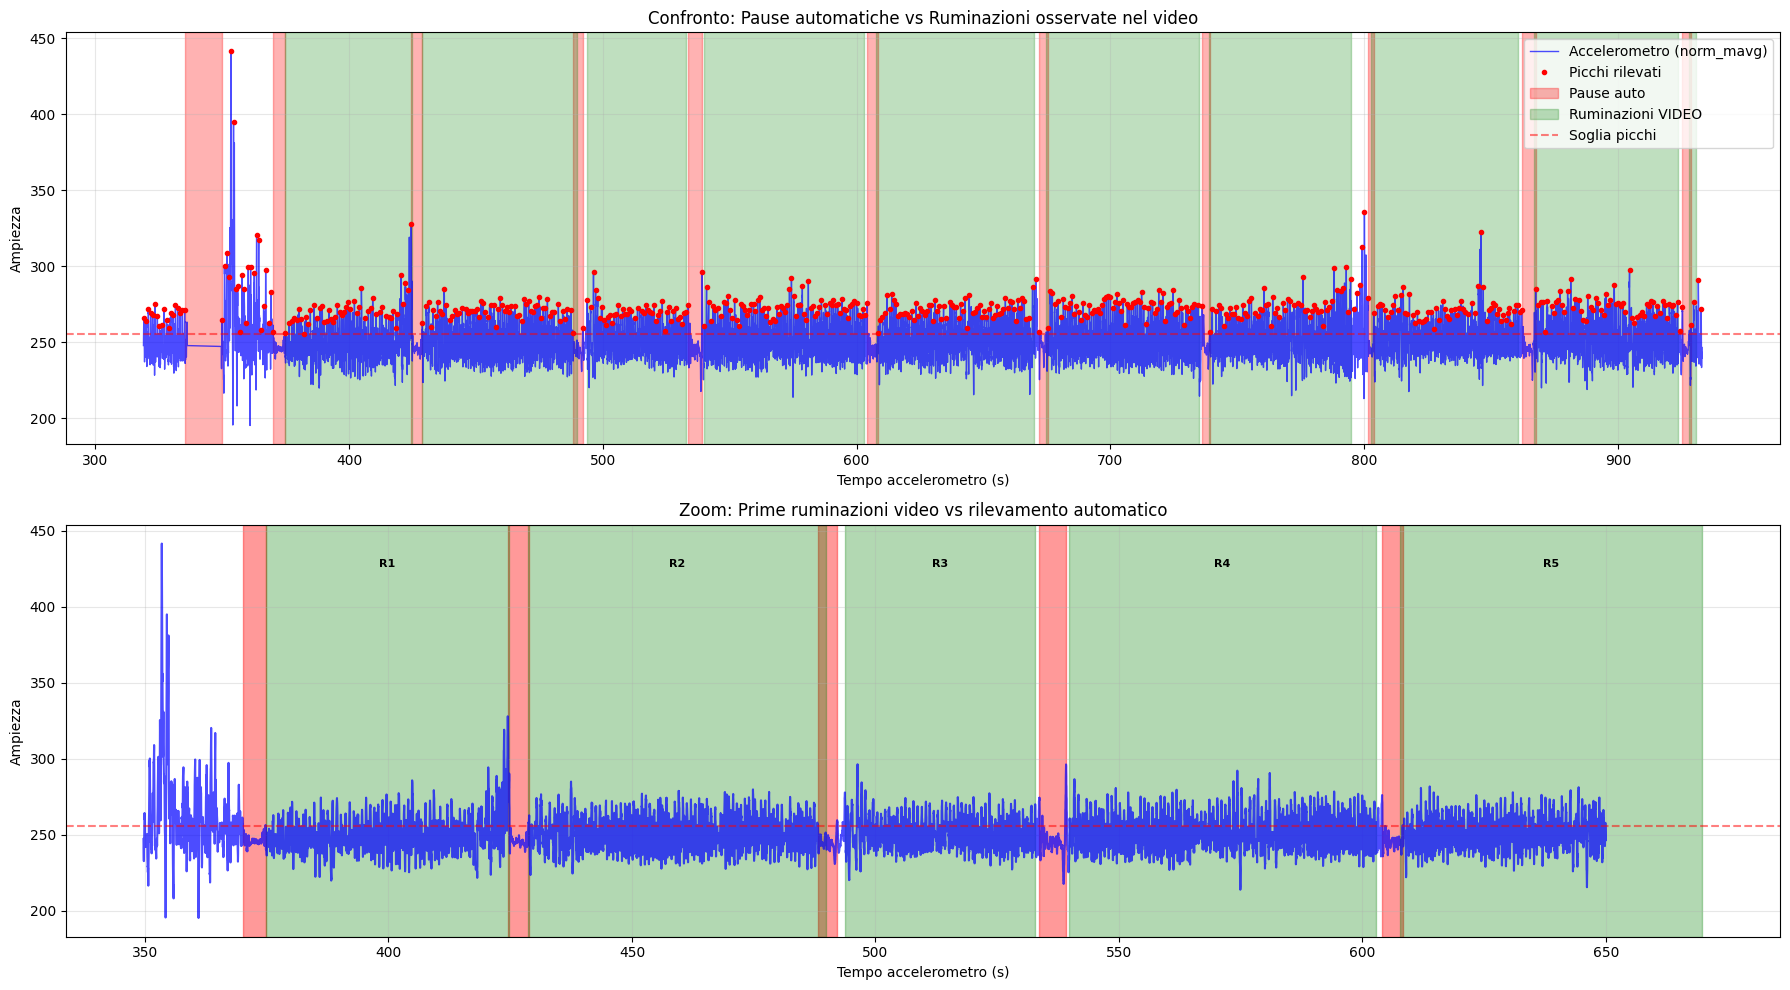


=== ANALISI CONFRONTO ===
Ruminazioni video: 10
Ruminazioni auto: 12

Sovrapposizioni trovate:
  Video R1 ↔ Auto R3: 100.0% (49.7s)
  Video R2 ↔ Auto R4: 100.0% (59.3s)
  Video R3 ↔ Auto R5: 100.0% (39.0s)
  Video R4 ↔ Auto R6: 100.0% (63.0s)
  Video R5 ↔ Auto R7: 99.2% (61.5s)
  Video R6 ↔ Auto R8: 99.1% (59.5s)
  Video R7 ↔ Auto R9: 99.4% (55.7s)
  Video R8 ↔ Auto R10: 98.3% (57.0s)
  Video R9 ↔ Auto R11: 98.6% (56.2s)
  Video R10 ↔ Auto R12: 65.9% (2.0s)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# === PARAMETRI SEMPLIFICATI ===
csv_path = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_processed.csv"
pause_threshold = 2.0           # soglia pause ridotta a 2s
after_time = 319.0              # tempo inizio analisi
long_rumination_threshold = 60  # ruminazioni "sospette" > 60s
peak_density_threshold = 0.15   # densità picchi minima (picchi/secondo)

# === RIFERIMENTI DAL VIDEO ===
# Il video inizia 25 secondi prima di 374.75s dell'accelerometro
video_start_accel = 374.75 - 25  # = 349.75s nell'accelerometro

# Conversione tempi video (mm:ss) in secondi accelerometro
video_ruminations = [
    (25, 75),    # 0:25 - 1:15
    (79, 140),   # 1:19 - 2:20  
    (144, 183),  # 2:24 - 3:03
    (190, 253),  # 3:10 - 4:13
    (258, 320),  # 4:18 - 5:20
    (325, 385),  # 5:25 - 6:25
    (389, 445),  # 6:29 - 7:25
    (453, 511),  # 7:33 - 8:31
    (517, 574),  # 8:37 - 9:34
    (578, 581)   # 9:38 - 9:41
]

# Converte in tempi accelerometro
accel_ruminations = []
for start_vid, end_vid in video_ruminations:
    start_accel = video_start_accel + start_vid
    end_accel = video_start_accel + end_vid
    accel_ruminations.append((start_accel, end_accel, end_accel - start_accel))

print("=== RIFERIMENTI DAL VIDEO (convertiti in tempi accelerometro) ===")
for i, (start, end, dur) in enumerate(accel_ruminations, 1):
    print(f"Ruminazione {i}: {start:.1f}s - {end:.1f}s (durata: {dur:.1f}s)")

# === CARICA DATI ===
df = pd.read_csv(csv_path)
if 'time_s' not in df.columns:
    if 'time_ms' in df.columns:
        df['time_s'] = df['time_ms'] / 1000.0
    else:
        raise ValueError("Manca la colonna 'time_s' o 'time_ms' nel CSV")

def detect_pauses_simple(df, signal_col='norm_mavg'):
    """Versione semplificata per rilevare pause"""
    time = df['time_s'].values
    signal = df[signal_col].values
    
    # Filtra dopo after_time
    mask = time >= after_time
    time = time[mask]
    signal = signal[mask]
    
    # Parametri base
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    height_thr = mean_val + 0.3 * std_val
    
    # Trova picchi
    fs = 1.0 / np.median(np.diff(time))
    min_dist = int(0.5 * fs)
    peaks_idx, _ = find_peaks(signal, height=height_thr, distance=min_dist)
    peaks_time = time[peaks_idx]
    peaks_values = signal[peaks_idx]
    
    # Trova pause base (tra picchi)
    pauses = []
    prev_time = time[0]
    for pt in peaks_time:
        if pt - prev_time >= pause_threshold:
            pauses.append((prev_time, pt, pt - prev_time))
        prev_time = pt
    
    # Controlla ruminazioni lunghe per pause nascoste
    ruminations_temp = []
    if pauses:
        start = time[0]
        for p_start, p_end, _ in sorted(pauses):
            if p_start > start:
                ruminations_temp.append((start, p_start, p_start - start))
            start = p_end
        if start < time[-1]:
            ruminations_temp.append((start, time[-1], time[-1] - start))
    else:
        ruminations_temp.append((time[0], time[-1], time[-1] - time[0]))
    
    # Verifica ruminazioni lunghe
    additional_pauses = []
    for rum_start, rum_end, rum_dur in ruminations_temp:
        if rum_dur > long_rumination_threshold:
            # Conta picchi nell'intervallo
            mask_rum = (time >= rum_start) & (time <= rum_end)
            signal_rum = signal[mask_rum]
            peaks_rum, _ = find_peaks(signal_rum, height=mean_val, distance=min_dist)
            
            density = len(peaks_rum) / rum_dur
            if density < peak_density_threshold:
                additional_pauses.append((rum_start, rum_end, rum_dur))
                print(f"🔍 Pausa nascosta trovata: {rum_start:.1f}-{rum_end:.1f}s (densità: {density:.3f})")
    
    # Unisci tutte le pause
    all_pauses = sorted(pauses + additional_pauses)
    
    # Ricalcola ruminazioni finali
    ruminations = []
    if all_pauses:
        start = time[0]
        for p_start, p_end, _ in all_pauses:
            if p_start > start:
                ruminations.append((start, p_start, p_start - start))
            start = p_end
        if start < time[-1]:
            ruminations.append((start, time[-1], time[-1] - start))
    else:
        ruminations.append((time[0], time[-1], time[-1] - time[0]))
    
    return time, signal, peaks_time, peaks_values, all_pauses, ruminations, height_thr

# === ANALISI ===
time, signal, peaks_time, peaks_values, pauses, ruminations, height_thr = detect_pauses_simple(df)

print(f"\n=== RISULTATI ACCELEROMETRO ===")
print(f"Pause automatiche trovate ({len(pauses)}):")
for i, (start, end, dur) in enumerate(pauses, 1):
    print(f"  {i}. {start:.1f}s - {end:.1f}s (durata: {dur:.1f}s)")

print(f"\nRuminazioni automatiche trovate ({len(ruminations)}):")
for i, (start, end, dur) in enumerate(ruminations, 1):
    print(f"  {i}. {start:.1f}s - {end:.1f}s (durata: {dur:.1f}s)")

# === GRAFICI ===
plt.figure(figsize=(18, 10))

# Grafico principale
plt.subplot(2, 1, 1)
plt.plot(time, signal, 'b-', alpha=0.7, linewidth=1, label='Accelerometro (norm_mavg)')
plt.plot(peaks_time, peaks_values, 'ro', markersize=3, label='Picchi rilevati')

# Pause automatiche (rosso)
for i, (start, end, dur) in enumerate(pauses):
    plt.axvspan(start, end, color='red', alpha=0.3, 
               label='Pause auto' if i == 0 else '')

# Ruminazioni dal video (verde)
for i, (start, end, dur) in enumerate(accel_ruminations):
    plt.axvspan(start, end, color='green', alpha=0.25,
               label='Ruminazioni VIDEO' if i == 0 else '')

plt.axhline(y=height_thr, color='red', linestyle='--', alpha=0.5, label='Soglia picchi')
plt.xlabel('Tempo accelerometro (s)')
plt.ylabel('Ampiezza')
plt.title('Confronto: Pause automatiche vs Ruminazioni osservate nel video')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom sulla zona iniziale
plt.subplot(2, 1, 2)
mask_zoom = (time >= 340) & (time <= 650)
time_zoom = time[mask_zoom]
signal_zoom = signal[mask_zoom]

plt.plot(time_zoom, signal_zoom, 'b-', alpha=0.7, linewidth=1.5)

# Pause e ruminazioni nella zona zoom
for start, end, dur in pauses:
    if start >= 340 and start <= 650:
        plt.axvspan(start, end, color='red', alpha=0.4)

for i, (start, end, dur) in enumerate(accel_ruminations):
    if start >= 340 and start <= 650:
        plt.axvspan(start, end, color='green', alpha=0.3)
        # Aggiungi numero ruminazione
        plt.text(start + dur/2, plt.ylim()[1]*0.95, f'R{i+1}', 
                ha='center', va='top', fontsize=8, fontweight='bold')

plt.axhline(y=height_thr, color='red', linestyle='--', alpha=0.5)
plt.xlabel('Tempo accelerometro (s)')
plt.ylabel('Ampiezza')
plt.title('Zoom: Prime ruminazioni video vs rilevamento automatico')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === ANALISI CONFRONTO ===
print(f"\n=== ANALISI CONFRONTO ===")
print(f"Ruminazioni video: {len(accel_ruminations)}")
print(f"Ruminazioni auto: {len(ruminations)}")

# Verifica sovrapposizioni
overlaps = []
for i, (rv_start, rv_end, rv_dur) in enumerate(accel_ruminations):
    for j, (ra_start, ra_end, ra_dur) in enumerate(ruminations):
        # Calcola sovrapposizione
        overlap_start = max(rv_start, ra_start)
        overlap_end = min(rv_end, ra_end)
        if overlap_start < overlap_end:
            overlap_dur = overlap_end - overlap_start
            overlap_perc = overlap_dur / min(rv_dur, ra_dur) * 100
            overlaps.append((i+1, j+1, overlap_perc, overlap_dur))

print(f"\nSovrapposizioni trovate:")
for vid_rum, auto_rum, perc, dur in overlaps:
    print(f"  Video R{vid_rum} ↔ Auto R{auto_rum}: {perc:.1f}% ({dur:.1f}s)")

<H1> PEAKS 


=== ANALISI CON METODO: XYZ_DETREND_ENHANCED ===
ID  Inizio   Fine     Dur    Manual  Rilevati  Accuracy  Rate/min
---------------------------------------------------------------------------
1   374.8    424.8    50.0   60      56        93.3     % 67.2    
2   428.8    489.8    61.0   68      87        72.1     % 85.6    
3   493.8    532.8    39.0   48      57        81.2     % 87.7    
4   539.8    602.8    63.0   78      100       71.8     % 95.2    
5   607.8    669.8    62.0   74      61        82.4     % 59.0    
6   674.8    734.8    60.0   73      69        94.5     % 69.0    
7   738.8    794.8    56.0   62      58        93.5     % 62.1    
8   802.8    860.8    58.0   70      57        81.4     % 59.0    
9   866.8    923.8    57.0   71      55        77.5     % 57.9    
10  927.8    930.8    3.0    3       3         100.0    % 60.0    
---------------------------------------------------------------------------
TOT                          607     603       99.3     %


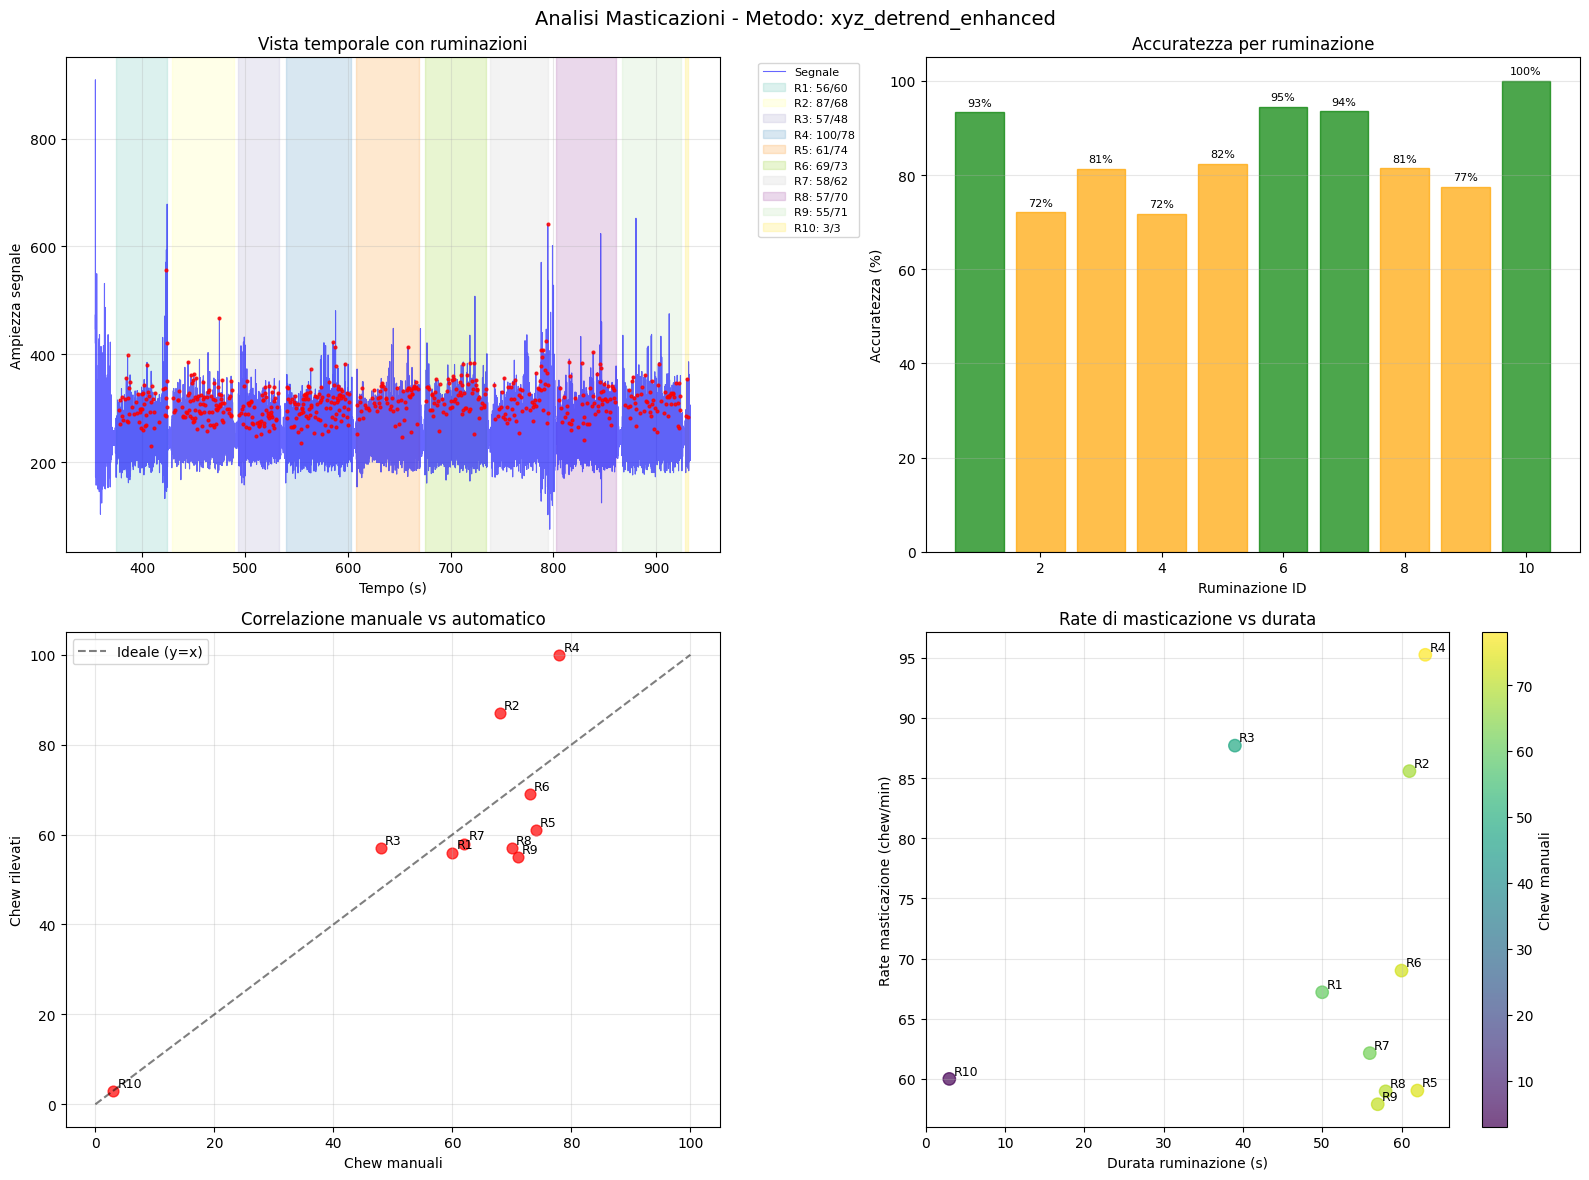


=== STATISTICHE FINALI ===
Metodo utilizzato: xyz_detrend_enhanced
Accuratezza complessiva: 99.3%
Errore medio assoluto: 10.4 chew
Deviazione standard errore: 7.0
Totale: 603 rilevati vs 607 manuali

Risultati salvati in: chew_analysis_results_20250814_154518.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter
from datetime import datetime

class ChewDetector:
    """Rilevatore di masticazioni ottimizzato basato sui risultati sperimentali"""
    
    def __init__(self, method='xyz_detrend_enhanced'):
        self.method = method
        self.signal_type, self.detection_type = method.split('_', 1)
        
    def prepare_signal(self, df):
        """Prepara il segnale ottimale basato sui risultati"""
        x, y, z = df['x'].values, df['y'].values, df['z'].values
        
        if self.signal_type == 'xyz_detrend':
            # Rimuovi offset gravitazionale da Y
            y_detrend = y - np.mean(y)
            signal = np.sqrt(x**2 + y_detrend**2 + z**2)
        elif self.signal_type == 'xyz':
            signal = np.sqrt(x**2 + y**2 + z**2)
        elif self.signal_type == 'yz':
            signal = np.sqrt(y**2 + z**2)
        elif self.signal_type == 'xz':
            signal = np.sqrt(x**2 + z**2)
        elif self.signal_type == 'xy':
            signal = np.sqrt(x**2 + y**2)
        elif self.signal_type == 'x':
            signal = np.abs(x)
        elif self.signal_type == 'y':
            signal = np.abs(y)
        elif self.signal_type == 'z':
            signal = np.abs(z)
        else:
            # fallback al segnale originale
            signal = df['norm_mavg'].values if 'norm_mavg' in df.columns else np.sqrt(x**2 + y**2 + z**2)
        
        return signal
    
    def calculate_sampling_rate(self, time_seg):
        """Calcola frequenza di campionamento robusta"""
        if len(time_seg) < 2:
            return None
        dt = np.diff(time_seg)
        dt_clean = dt[dt > 0]
        return 1.0 / np.median(dt_clean) if len(dt_clean) > 0 else None
    
    def filter_signal(self, signal, fs):
        """Applica filtri per evidenziare le masticazioni"""
        try:
            # Filtro passa-banda 1-4 Hz (frequenza tipica masticazione)
            nyquist = 0.5 * fs
            low_norm = 1.0 / nyquist
            high_norm = 4.0 / nyquist
            
            if 0 < low_norm < high_norm < 1:
                b, a = butter(3, [low_norm, high_norm], btype='band')
                filtered = filtfilt(b, a, signal)
                
                # Smooth con Savitzky-Golay
                if len(filtered) > 21:
                    window_len = min(21, len(filtered)//2*2-1)
                    filtered = savgol_filter(filtered, window_len, 3)
                
                return filtered
        except:
            pass
        
        # Fallback: solo detrend
        return signal - np.mean(signal)
    
    def remove_outliers(self, signal, factor=1.5):
        """Rimuove outlier usando IQR"""
        Q1 = np.percentile(signal, 25)
        Q3 = np.percentile(signal, 75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        return np.clip(signal, lower, upper)
    
    def detect_chews(self, time, signal, start_time, end_time):
        """Rileva masticazioni in un intervallo temporale"""
        # Estrai segmento
        mask = (time >= start_time) & (time <= end_time)
        time_seg = time[mask]
        signal_seg = signal[mask]
        
        if len(signal_seg) < 20:
            return 0, np.array([]), {}
        
        # Calcola frequenza di campionamento
        fs = self.calculate_sampling_rate(time_seg)
        if fs is None or fs <= 0:
            return 0, np.array([]), {'error': 'Invalid sampling rate'}
        
        # Pre-processing
        signal_clean = self.remove_outliers(signal_seg)
        signal_filtered = self.filter_signal(signal_clean, fs)
        
        # Parametri adattivi
        signal_std = np.std(signal_filtered)
        signal_mean = np.mean(np.abs(signal_filtered))
        
        if signal_std == 0:
            return 0, np.array([]), {'error': 'Zero variance signal'}
        
        # Soglie conservative
        height_thr = max(0.5 * signal_std, 0.1 * signal_mean)
        prominence_thr = 0.3 * signal_std
        min_distance = max(int(0.3 * fs), 5)  # min 300ms tra chew
        
        # Rilevazione picchi
        peaks_idx, props = find_peaks(signal_filtered, 
                                    height=height_thr,
                                    prominence=prominence_thr,
                                    distance=min_distance,
                                    width=(2, None))
        
        # Filtra per intensità (top 40% dei picchi)
        if len(peaks_idx) > 0:
            prominences = props['prominences']
            prom_threshold = np.percentile(prominences, 60)
            strong_peaks = peaks_idx[prominences >= prom_threshold]
            chew_times = time_seg[strong_peaks] if len(strong_peaks) > 0 else np.array([])
            
            stats = {
                'fs': fs,
                'n_points': len(signal_seg),
                'height_thr': height_thr,
                'prominence_thr': prominence_thr,
                'n_all_peaks': len(peaks_idx),
                'n_strong_peaks': len(strong_peaks),
                'signal_std': signal_std
            }
            
            return len(strong_peaks), chew_times, stats
        
        return 0, np.array([]), {'fs': fs, 'n_points': len(signal_seg)}
    
    def analyze_ruminations(self, df, rumination_intervals, manual_counts=None):
        """Analizza una serie di ruminazioni"""
        time = df['time_s'].values
        signal = self.prepare_signal(df)
        
        results = []
        total_manual = 0
        total_detected = 0
        
        print(f"=== ANALISI CON METODO: {self.method.upper()} ===")
        print(f"{'ID':<3} {'Inizio':<8} {'Fine':<8} {'Dur':<6} {'Manual':<7} {'Rilevati':<9} {'Accuracy':<9} {'Rate/min':<8}")
        print("-" * 75)
        
        for i, (start, end, duration) in enumerate(rumination_intervals, 1):
            manual_chews = manual_counts[i-1] if manual_counts else 0
            
            # Rileva masticazioni
            detected, chew_times, stats = self.detect_chews(time, signal, start, end)
            
            # Calcola accuratezza
            if manual_chews > 0:
                accuracy = (1 - abs(detected - manual_chews) / manual_chews) * 100
            else:
                accuracy = 100 if detected == 0 else 0
            
            # Rate di masticazione
            chew_rate = detected / duration * 60 if duration > 0 else 0
            
            print(f"{i:<3} {start:<8.1f} {end:<8.1f} {duration:<6.1f} {manual_chews:<7} {detected:<9} {accuracy:<9.1f}% {chew_rate:<8.1f}")
            
            results.append({
                'id': i,
                'start': start, 'end': end, 'duration': duration,
                'manual': manual_chews, 'detected': detected,
                'accuracy': accuracy, 'chew_rate': chew_rate,
                'chew_times': chew_times, 'stats': stats
            })
            
            total_manual += manual_chews
            total_detected += detected
        
        # Statistiche complessive
        if total_manual > 0:
            overall_accuracy = (1 - abs(total_detected - total_manual) / total_manual) * 100
        else:
            overall_accuracy = 100 if total_detected == 0 else 0
        
        print("-" * 75)
        print(f"TOT {'':<8} {'':<8} {'':<6} {total_manual:<7} {total_detected:<9} {overall_accuracy:<9.1f}%")
        
        return results, {
            'total_manual': total_manual,
            'total_detected': total_detected,
            'overall_accuracy': overall_accuracy,
            'mean_error': np.mean([abs(r['detected'] - r['manual']) for r in results]),
            'std_error': np.std([abs(r['detected'] - r['manual']) for r in results])
        }
    
    def plot_results(self, df, results, stats):
        """Crea grafici dei risultati"""
        time = df['time_s'].values
        signal = self.prepare_signal(df)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'Analisi Masticazioni - Metodo: {self.method}', fontsize=14)
        
        # 1. Overview temporale
        ax1 = axes[0, 0]
        
        # Mostra solo una finestra interessante
        time_start = max(350, min([r['start'] for r in results]) - 20)
        time_end = min(time.max(), max([r['end'] for r in results]) + 20)
        mask = (time >= time_start) & (time <= time_end)
        
        ax1.plot(time[mask], signal[mask], 'b-', alpha=0.6, linewidth=0.8, label='Segnale')
        
        # Evidenzia ruminazioni
        colors = plt.cm.Set3(np.linspace(0, 1, len(results)))
        for r, color in zip(results, colors):
            ax1.axvspan(r['start'], r['end'], color=color, alpha=0.3, 
                       label=f"R{r['id']}: {r['detected']}/{r['manual']}")
            
            # Mostra chew rilevati
            if len(r['chew_times']) > 0:
                chew_vals = np.interp(r['chew_times'], time, signal)
                ax1.plot(r['chew_times'], chew_vals, 'ro', markersize=2, alpha=0.8)
        
        ax1.set_xlabel('Tempo (s)')
        ax1.set_ylabel('Ampiezza segnale')
        ax1.set_title('Vista temporale con ruminazioni')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Accuratezza per ruminazione
        ax2 = axes[0, 1]
        rum_ids = [r['id'] for r in results]
        accuracies = [r['accuracy'] for r in results]
        
        bars = ax2.bar(rum_ids, accuracies, alpha=0.7)
        for i, (bar, acc) in enumerate(zip(bars, accuracies)):
            if acc >= 90:
                bar.set_color('green')
            elif acc >= 70:
                bar.set_color('orange')
            else:
                bar.set_color('red')
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{acc:.0f}%', ha='center', va='bottom', fontsize=8)
        
        ax2.set_xlabel('Ruminazione ID')
        ax2.set_ylabel('Accuratezza (%)')
        ax2.set_title('Accuratezza per ruminazione')
        ax2.set_ylim(0, 105)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. Correlazione manuale vs automatico
        ax3 = axes[1, 0]
        manual_counts = [r['manual'] for r in results]
        detected_counts = [r['detected'] for r in results]
        
        ax3.scatter(manual_counts, detected_counts, s=60, alpha=0.7, c='red')
        for r in results:
            ax3.annotate(f"R{r['id']}", (r['manual'], r['detected']), 
                        xytext=(3, 3), textcoords='offset points', fontsize=9)
        
        # Linea ideale
        max_val = max(max(manual_counts), max(detected_counts))
        ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Ideale (y=x)')
        
        ax3.set_xlabel('Chew manuali')
        ax3.set_ylabel('Chew rilevati')
        ax3.set_title('Correlazione manuale vs automatico')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Rate di masticazione
        ax4 = axes[1, 1]
        durations = [r['duration'] for r in results]
        chew_rates = [r['chew_rate'] for r in results]
        
        scatter = ax4.scatter(durations, chew_rates, s=80, alpha=0.7, 
                             c=manual_counts, cmap='viridis')
        plt.colorbar(scatter, ax=ax4, label='Chew manuali')
        
        for r in results:
            ax4.annotate(f"R{r['id']}", (r['duration'], r['chew_rate']), 
                        xytext=(3, 3), textcoords='offset points', fontsize=9)
        
        ax4.set_xlabel('Durata ruminazione (s)')
        ax4.set_ylabel('Rate masticazione (chew/min)')
        ax4.set_title('Rate di masticazione vs durata')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Stampa statistiche finali
        print(f"\n=== STATISTICHE FINALI ===")
        print(f"Metodo utilizzato: {self.method}")
        print(f"Accuratezza complessiva: {stats['overall_accuracy']:.1f}%")
        print(f"Errore medio assoluto: {stats['mean_error']:.1f} chew")
        print(f"Deviazione standard errore: {stats['std_error']:.1f}")
        print(f"Totale: {stats['total_detected']} rilevati vs {stats['total_manual']} manuali")

# === USO DEL RILEVATORE ===
if __name__ == "__main__":
    # Parametri
    csv_path = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_processed.csv"
    video_start_accel = 374.75 - 25
    
    # Dati video
    video_data = [
        (25, 75, 60), (79, 140, 68), (144, 183, 48), (190, 253, 78), (258, 320, 74),
        (325, 385, 73), (389, 445, 62), (453, 511, 70), (517, 574, 71), (578, 581, 3)
    ]
    
    # Converti in tempi accelerometro
    rumination_intervals = []
    manual_counts = []
    
    for start_vid, end_vid, chew_count in video_data:
        start_accel = video_start_accel + start_vid
        end_accel = video_start_accel + end_vid
        duration = end_accel - start_accel
        rumination_intervals.append((start_accel, end_accel, duration))
        manual_counts.append(chew_count)
    
    # Carica dati
    df = pd.read_csv(csv_path)
    if 'time_s' not in df.columns:
        if 'time_ms' in df.columns:
            df['time_s'] = df['time_ms'] / 1000.0
        else:
            raise ValueError("Manca colonna time_s o time_ms")
    
    # Crea rilevatore con il metodo migliore
    detector = ChewDetector(method='xyz_detrend_enhanced')
    
    # Analizza ruminazioni
    results, stats = detector.analyze_ruminations(df, rumination_intervals, manual_counts)
    
    # Crea grafici
    detector.plot_results(df, results, stats)
    
    # Esporta risultati
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_df = pd.DataFrame([{
        'rumination_id': r['id'],
        'start_time': r['start'],
        'end_time': r['end'],
        'duration_s': r['duration'],
        'manual_chews': r['manual'],
        'detected_chews': r['detected'],
        'accuracy_percent': r['accuracy'],
        'chew_rate_per_min': r['chew_rate'],
        'sampling_rate_hz': r['stats'].get('fs', 0),
        'n_data_points': r['stats'].get('n_points', 0)
    } for r in results])
    
    output_path = f"chew_analysis_results_{timestamp}.csv"
    results_df.to_csv(output_path, index=False)
    print(f"\nRisultati salvati in: {output_path}")

=== RUMINAZIONI DAL VIDEO ===
Rum 1: 374.8-424.8s (50.0s) → 60 chew (72.0 chew/min)
Rum 2: 428.8-489.8s (61.0s) → 68 chew (66.9 chew/min)
Rum 3: 493.8-532.8s (39.0s) → 48 chew (73.8 chew/min)
Rum 4: 539.8-602.8s (63.0s) → 78 chew (74.3 chew/min)
Rum 5: 607.8-669.8s (62.0s) → 74 chew (71.6 chew/min)
Rum 6: 674.8-734.8s (60.0s) → 73 chew (73.0 chew/min)
Rum 7: 738.8-794.8s (56.0s) → 62 chew (66.4 chew/min)
Rum 8: 802.8-860.8s (58.0s) → 70 chew (72.4 chew/min)
Rum 9: 866.8-923.8s (57.0s) → 71 chew (74.7 chew/min)
Rum 10: 927.8-930.8s (3.0s) → 3 chew (60.0 chew/min)

=== ANALISI ASSI ===
X: min=-1927.0, max=1035.0, std=  70.1
Y: min=-797.0, max=1376.0, std= 146.3
Z: min=-1788.0, max=1267.0, std=  69.8

Range temporale: 0.0 - 933.1s
Segnali testati: ['xyz', 'xyz_detrend', 'xz', 'xy', 'yz', 'x', 'y', 'z', 'original']
Metodi: enhanced, frequency
Combinazioni totali: 18

=== TESTING TUTTI I METODI SU TUTTI GLI INTERVALLI ===
Elaborazione Ruminazione 1 (374.8-424.8s, 60 chew manuali)...
Elabora

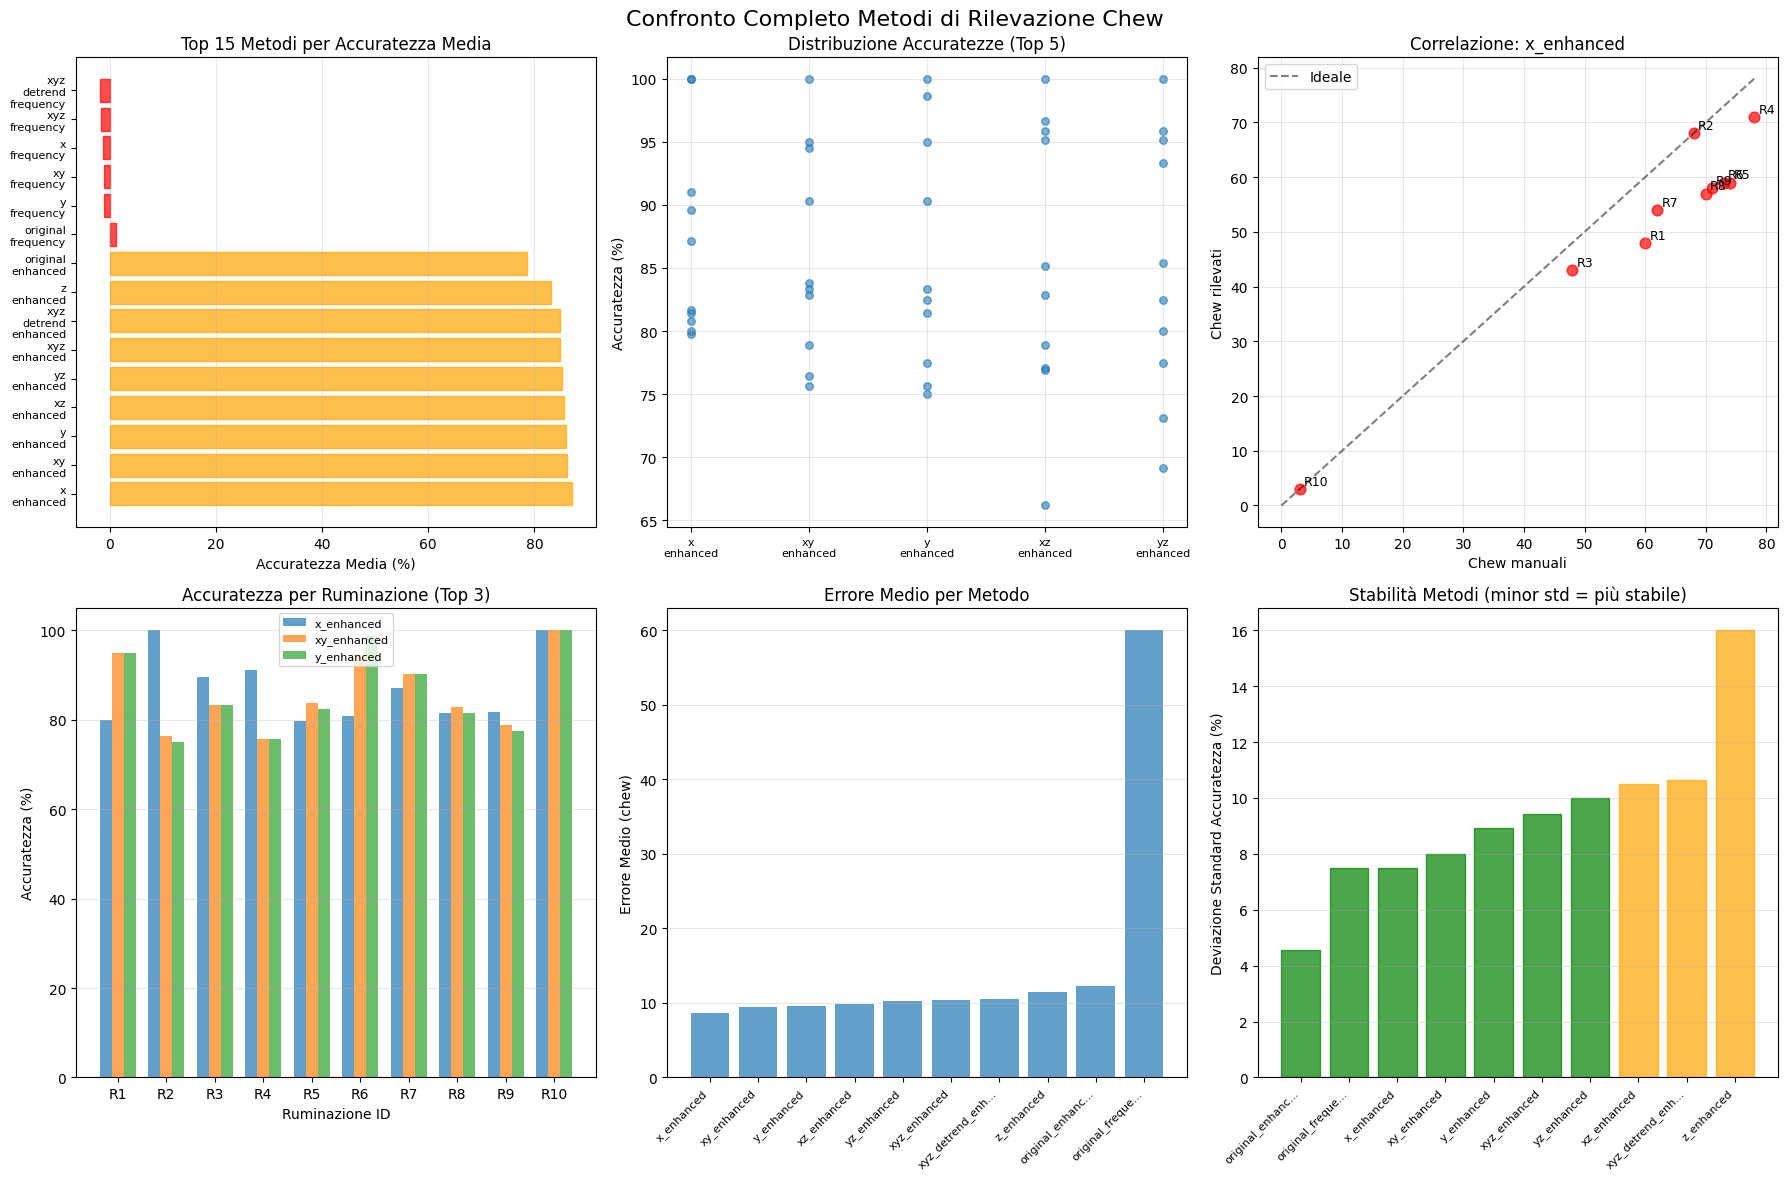


=== RACCOMANDAZIONE FINALE ===
Miglior metodo: x_enhanced
Accuratezza media per intervallo: 87.1%
Stabilità (std accuratezza): 7.5%
Errore medio: 8.7 chew per ruminazione


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, welch, savgol_filter
from scipy.stats import zscore

# === PARAMETRI ===
csv_path = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_processed.csv"

# === DATI DALLE TUE OSSERVAZIONI VIDEO ===
video_start_accel = 374.75 - 25

video_ruminations_data = [
    (25, 75, 60), (79, 140, 68), (144, 183, 48), (190, 253, 78), (258, 320, 74),
    (325, 385, 73), (389, 445, 62), (453, 511, 70), (517, 574, 71), (578, 581, 3)
]

# Converti in tempi accelerometro
accel_ruminations_data = []
for start_vid, end_vid, chew_count in video_ruminations_data:
    start_accel = video_start_accel + start_vid
    end_accel = video_start_accel + end_vid
    duration = end_accel - start_accel
    accel_ruminations_data.append((start_accel, end_accel, duration, chew_count))

print("=== RUMINAZIONI DAL VIDEO ===")
for i, (start, end, dur, chews) in enumerate(accel_ruminations_data, 1):
    chew_rate = chews / dur * 60
    print(f"Rum {i}: {start:.1f}-{end:.1f}s ({dur:.1f}s) → {chews} chew ({chew_rate:.1f} chew/min)")

# === CARICA DATI ===
df = pd.read_csv(csv_path)
if 'time_s' not in df.columns:
    if 'time_ms' in df.columns:
        df['time_s'] = df['time_ms'] / 1000.0
    else:
        raise ValueError("Manca la colonna time_s o time_ms")

time = df['time_s'].values

# === PREPARAZIONE SEGNALI ===
def prepare_all_signals():
    """Prepara tutti i tipi di segnali"""
    x, y, z = df['x'].values, df['y'].values, df['z'].values
    
    print(f"\n=== ANALISI ASSI ===")
    print(f"X: min={x.min():6.1f}, max={x.max():6.1f}, std={x.std():6.1f}")
    print(f"Y: min={y.min():6.1f}, max={y.max():6.1f}, std={y.std():6.1f}")
    print(f"Z: min={z.min():6.1f}, max={z.max():6.1f}, std={z.std():6.1f}")
    
    # Calcola tutte le combinazioni possibili
    signals = {}
    
    # Norme complete
    signals['xyz'] = np.sqrt(x**2 + y**2 + z**2)
    
    # Y detrended (rimuovi offset gravitazionale)
    y_detrend = y - np.mean(y)
    signals['xyz_detrend'] = np.sqrt(x**2 + y_detrend**2 + z**2)
    
    # Combinazioni parziali
    signals['xz'] = np.sqrt(x**2 + z**2)
    signals['xy'] = np.sqrt(x**2 + y**2)  
    signals['yz'] = np.sqrt(y**2 + z**2)
    
    # Assi individuali
    signals['x'] = np.abs(x)
    signals['y'] = np.abs(y) 
    signals['z'] = np.abs(z)
    
    # Segnale originale se disponibile
    if 'norm_mavg' in df.columns:
        signals['original'] = df['norm_mavg'].values
    
    return signals

def calculate_sampling_rate(time_seg):
    """Calcola frequenza di campionamento robusta"""
    if len(time_seg) < 2:
        return None
    dt = np.diff(time_seg)
    dt_clean = dt[dt > 0]
    if len(dt_clean) == 0:
        return None
    return 1.0 / np.median(dt_clean)

def butter_filter_safe(data, cutoff, fs, ftype='low', order=4):
    """Filtro sicuro con controlli"""
    try:
        nyquist = 0.5 * fs
        if ftype == 'bandpass':
            if isinstance(cutoff, (list, tuple)) and len(cutoff) == 2:
                low, high = cutoff
                low_norm = low / nyquist
                high_norm = high / nyquist
                if 0 < low_norm < high_norm < 1:
                    b, a = butter(order, [low_norm, high_norm], btype='band')
                    return filtfilt(b, a, data)
        else:
            normal_cutoff = cutoff / nyquist
            if 0 < normal_cutoff < 1:
                b, a = butter(order, normal_cutoff, btype=ftype)
                return filtfilt(b, a, data)
    except:
        pass
    return data - np.mean(data)

def remove_outliers_iqr(signal, factor=2.0):
    """Rimuove outlier usando IQR"""
    Q1 = np.percentile(signal, 25)
    Q3 = np.percentile(signal, 75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return np.clip(signal, lower, upper)

def detect_chews_enhanced(time_seg, signal_seg, fs):
    """Metodo enhanced per rilevazione chew"""
    if len(signal_seg) < 20 or fs is None or fs <= 0:
        return 0, []
    
    # Pre-processing: rimuovi outlier
    signal_clean = remove_outliers_iqr(signal_seg, factor=1.5)
    
    # Filtro passa-banda specifico per masticazione (1-4 Hz)
    signal_filtered = butter_filter_safe(signal_clean, [1.0, 4.0], fs, 'bandpass', order=3)
    
    # Smooth con Savitzky-Golay per ridurre rumore
    if len(signal_filtered) > 21:
        window_len = min(21, len(signal_filtered)//2*2-1)
        signal_smooth = savgol_filter(signal_filtered, window_len, 3)
    else:
        signal_smooth = signal_filtered
    
    # Parametri adattivi basati sul segnale
    signal_std = np.std(signal_smooth)
    signal_mean = np.mean(np.abs(signal_smooth))
    
    if signal_std == 0:
        return 0, []
    
    # Soglie conservative
    height_thr = max(0.5 * signal_std, 0.1 * signal_mean)
    prominence_thr = 0.3 * signal_std
    min_distance = max(int(0.3 * fs), 5)  # min 300ms tra chew
    
    # Trova picchi principali
    peaks_idx, props = find_peaks(signal_smooth, 
                                height=height_thr,
                                prominence=prominence_thr,
                                distance=min_distance,
                                width=(2, None))
    
    # Filtra per intensità (solo i più prominenti)
    if len(peaks_idx) > 0:
        prominences = props['prominences']
        prom_threshold = np.percentile(prominences, 60)  # top 40%
        strong_peaks = peaks_idx[prominences >= prom_threshold]
        chew_times = time_seg[strong_peaks] if len(strong_peaks) > 0 else np.array([])
        return len(strong_peaks), chew_times
    
    return 0, []

def detect_chews_frequency(time_seg, signal_seg, fs):
    """Metodo frequency per rilevazione chew"""
    if len(signal_seg) < 20 or fs is None or fs <= 0:
        return 0, []
    
    # Analisi di frequenza solo se abbastanza punti
    if len(signal_seg) >= fs * 5:  # almeno 5 secondi
        try:
            freqs, psd = welch(signal_seg, fs, nperseg=min(512, len(signal_seg)//4))
            # Trova picco dominante nella banda 1-4 Hz
            chew_band = (freqs >= 1) & (freqs <= 4)
            if np.any(chew_band):
                dominant_freq = freqs[chew_band][np.argmax(psd[chew_band])]
                expected_interval = 1.0 / dominant_freq * fs
                
                # Usa l'intervallo stimato per la rilevazione
                signal_filt = butter_filter_safe(signal_seg, [0.8*dominant_freq, 1.2*dominant_freq], fs, 'bandpass')
                peaks_idx, _ = find_peaks(signal_filt, distance=int(0.7*expected_interval))
                chew_times = time_seg[peaks_idx] if len(peaks_idx) > 0 else np.array([])
                return len(peaks_idx), chew_times
        except:
            pass
    
    return 0, []

def test_all_methods_on_interval(time, signals_dict, start_time, end_time):
    """Testa tutti i metodi su un singolo intervallo"""
    # Estrai segmento temporale
    mask = (time >= start_time) & (time <= end_time)
    time_seg = time[mask]
    
    if len(time_seg) < 20:
        return {}
    
    fs = calculate_sampling_rate(time_seg)
    if fs is None or fs <= 0:
        return {}
    
    results = {}
    
    # Testa ogni segnale con entrambi i metodi
    for signal_name, signal in signals_dict.items():
        signal_seg = signal[mask]
        
        # Metodo enhanced
        count_enh, times_enh = detect_chews_enhanced(time_seg, signal_seg, fs)
        
        # Metodo frequency  
        count_freq, times_freq = detect_chews_frequency(time_seg, signal_seg, fs)
        
        results[f"{signal_name}_enhanced"] = (count_enh, times_enh)
        results[f"{signal_name}_frequency"] = (count_freq, times_freq)
    
    return results

# === ANALISI COMPLETA ===
signals = prepare_all_signals()

print(f"\nRange temporale: {time.min():.1f} - {time.max():.1f}s")
print(f"Segnali testati: {list(signals.keys())}")
print(f"Metodi: enhanced, frequency")
print(f"Combinazioni totali: {len(signals) * 2}")

# Testa tutti i metodi su tutti gli intervalli
all_method_results = {}  # {method_name: [(rum_id, manual, detected, accuracy), ...]}

print(f"\n=== TESTING TUTTI I METODI SU TUTTI GLI INTERVALLI ===")

for i, (start, end, dur, manual_chews) in enumerate(accel_ruminations_data, 1):
    if start < time.min() or end > time.max():
        print(f"Ruminazione {i}: fuori dal range temporale, saltata")
        continue
    
    print(f"Elaborazione Ruminazione {i} ({start:.1f}-{end:.1f}s, {manual_chews} chew manuali)...")
    
    # Testa tutti i metodi su questo intervallo
    interval_results = test_all_methods_on_interval(time, signals, start, end)
    
    # Salva i risultati per ogni metodo
    for method_name, (detected_count, chew_times) in interval_results.items():
        
        # Calcola accuratezza per questo intervallo
        if manual_chews > 0:
            accuracy = (1 - abs(detected_count - manual_chews) / manual_chews) * 100
        else:
            accuracy = 100 if detected_count == 0 else 0
        
        # Inizializza lista se non esiste
        if method_name not in all_method_results:
            all_method_results[method_name] = []
        
        # Aggiungi risultato
        all_method_results[method_name].append((i, manual_chews, detected_count, accuracy))

# === CALCOLA STATISTICHE PER METODO (MEDIA DELLE ACCURATEZZE PER INTERVALLO) ===
print(f"\n=== CLASSIFICA METODI PER ACCURATEZZA MEDIA ===")
print(f"{'Metodo':<25} {'Acc_Media%':<10} {'Acc_Min%':<9} {'Acc_Max%':<9} {'Tot_M':<6} {'Tot_D':<6} {'Err_Med':<7}")
print("-" * 85)

method_performance = []

for method_name, results in all_method_results.items():
    if not results:  # Skip se nessun risultato
        continue
    
    # Estrai dati
    accuracies = [r[3] for r in results]  # accuracy per intervallo
    manual_counts = [r[1] for r in results]  # manual chews
    detected_counts = [r[2] for r in results]  # detected chews
    
    # Statistiche
    mean_accuracy = np.mean(accuracies)  # MEDIA DELLE ACCURATEZZE PER INTERVALLO
    min_accuracy = np.min(accuracies)
    max_accuracy = np.max(accuracies)
    total_manual = sum(manual_counts)
    total_detected = sum(detected_counts)
    mean_error = np.mean([abs(d - m) for m, d in zip(manual_counts, detected_counts)])
    
    method_performance.append({
        'method': method_name,
        'mean_acc': mean_accuracy,
        'min_acc': min_accuracy, 
        'max_acc': max_accuracy,
        'total_manual': total_manual,
        'total_detected': total_detected,
        'mean_error': mean_error,
        'accuracies': accuracies,
        'results': results
    })
    
    print(f"{method_name:<25} {mean_accuracy:<10.1f} {min_accuracy:<9.1f} {max_accuracy:<9.1f} {total_manual:<6} {total_detected:<6} {mean_error:<7.1f}")

# Ordina per accuratezza media
method_performance.sort(key=lambda x: x['mean_acc'], reverse=True)

print(f"\n=== TOP 10 METODI ===")
for i, mp in enumerate(method_performance[:10], 1):
    print(f"{i:2}. {mp['method']:<25} → Accuratezza media: {mp['mean_acc']:.1f}%")

# === DETTAGLIO DEL MIGLIOR METODO ===
if method_performance:
    best_method = method_performance[0]
    print(f"\n=== DETTAGLIO MIGLIOR METODO: {best_method['method']} ===")
    print(f"{'Rum':<3} {'Manual':<7} {'Rilevati':<9} {'Accuracy%':<10}")
    print("-" * 35)
    
    for rum_id, manual, detected, accuracy in best_method['results']:
        print(f"{rum_id:<3} {manual:<7} {detected:<9} {accuracy:<10.1f}")
    
    print(f"\nStatistiche:")
    print(f"- Accuratezza media per intervallo: {best_method['mean_acc']:.1f}%")
    print(f"- Range accuratezza: {best_method['min_acc']:.1f}% - {best_method['max_acc']:.1f}%")
    print(f"- Errore medio assoluto: {best_method['mean_error']:.1f} chew")
    print(f"- Deviazione standard accuratezza: {np.std(best_method['accuracies']):.1f}%")

# === GRAFICI COMPARATIVI ===
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confronto Completo Metodi di Rilevazione Chew', fontsize=16)

# 1. Ranking accuratezza media
ax1 = axes[0, 0]
top_methods = method_performance[:15]  # top 15
method_names = [m['method'].replace('_', '\n') for m in top_methods]
mean_accs = [m['mean_acc'] for m in top_methods]

bars = ax1.barh(range(len(method_names)), mean_accs, alpha=0.7)
ax1.set_yticks(range(len(method_names)))
ax1.set_yticklabels(method_names, fontsize=8)
ax1.set_xlabel('Accuratezza Media (%)')
ax1.set_title('Top 15 Metodi per Accuratezza Media')
ax1.grid(True, alpha=0.3, axis='x')

# Colora barre
for i, bar in enumerate(bars):
    if mean_accs[i] >= 90:
        bar.set_color('green')
    elif mean_accs[i] >= 70:
        bar.set_color('orange')
    else:
        bar.set_color('red')

# 2. Distribuzione accuratezze (top 5 metodi)
ax2 = axes[0, 1]
top_5 = method_performance[:5]
positions = []
data_to_plot = []
labels = []

for i, mp in enumerate(top_5):
    positions.extend([i+1] * len(mp['accuracies']))
    data_to_plot.extend(mp['accuracies'])
    labels.append(mp['method'].replace('_', '\n'))

ax2.scatter(positions, data_to_plot, alpha=0.6, s=30)
ax2.set_xticks(range(1, len(top_5)+1))
ax2.set_xticklabels(labels, fontsize=8)
ax2.set_ylabel('Accuratezza (%)')
ax2.set_title('Distribuzione Accuratezze (Top 5)')
ax2.grid(True, alpha=0.3)

# 3. Correlazione per miglior metodo
if method_performance:
    ax3 = axes[0, 2]
    best = method_performance[0]
    manual_vals = [r[1] for r in best['results']]
    detected_vals = [r[2] for r in best['results']]
    rum_ids = [r[0] for r in best['results']]
    
    ax3.scatter(manual_vals, detected_vals, alpha=0.7, s=60, c='red')
    for i, rid in enumerate(rum_ids):
        ax3.annotate(f'R{rid}', (manual_vals[i], detected_vals[i]), 
                    xytext=(3, 3), textcoords='offset points', fontsize=9)
    
    # Linea ideale
    max_val = max(max(manual_vals), max(detected_vals))
    ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Ideale')
    
    ax3.set_xlabel('Chew manuali')
    ax3.set_ylabel('Chew rilevati')
    ax3.set_title(f'Correlazione: {best["method"]}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Confronto per ruminazione (top 3 metodi)
ax4 = axes[1, 0]
top_3 = method_performance[:3]
rum_ids = sorted(set([r[0] for results in [m['results'] for m in top_3] for r in results]))

x = np.arange(len(rum_ids))
width = 0.25

for i, mp in enumerate(top_3):
    accuracies_by_rum = {}
    for rum_id, manual, detected, accuracy in mp['results']:
        accuracies_by_rum[rum_id] = accuracy
    
    y_vals = [accuracies_by_rum.get(rid, 0) for rid in rum_ids]
    ax4.bar(x + i*width, y_vals, width, label=mp['method'], alpha=0.7)

ax4.set_xlabel('Ruminazione ID')
ax4.set_ylabel('Accuratezza (%)')
ax4.set_title('Accuratezza per Ruminazione (Top 3)')
ax4.set_xticks(x + width)
ax4.set_xticklabels([f'R{rid}' for rid in rum_ids])
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Errore medio per metodo
ax5 = axes[1, 1]
top_10 = method_performance[:10]
method_names_short = [m['method'][:15] + '...' if len(m['method']) > 15 else m['method'] for m in top_10]
errors = [m['mean_error'] for m in top_10]

bars = ax5.bar(range(len(method_names_short)), errors, alpha=0.7)
ax5.set_xticks(range(len(method_names_short)))
ax5.set_xticklabels(method_names_short, rotation=45, ha='right', fontsize=8)
ax5.set_ylabel('Errore Medio (chew)')
ax5.set_title('Errore Medio per Metodo')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Variabilità accuratezza
ax6 = axes[1, 2]
top_10_std = [(m['method'], np.std(m['accuracies'])) for m in method_performance[:10]]
top_10_std.sort(key=lambda x: x[1])  # ordina per std crescente

methods_stable = [m[0][:15] + '...' if len(m[0]) > 15 else m[0] for m in top_10_std]
stds = [m[1] for m in top_10_std]

bars = ax6.bar(range(len(methods_stable)), stds, alpha=0.7)
ax6.set_xticks(range(len(methods_stable)))
ax6.set_xticklabels(methods_stable, rotation=45, ha='right', fontsize=8)
ax6.set_ylabel('Deviazione Standard Accuratezza (%)')
ax6.set_title('Stabilità Metodi (minor std = più stabile)')
ax6.grid(True, alpha=0.3, axis='y')

# Colora: verde = più stabile
for i, bar in enumerate(bars):
    if stds[i] <= 10:
        bar.set_color('green')
    elif stds[i] <= 20:
        bar.set_color('orange') 
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

print(f"\n=== RACCOMANDAZIONE FINALE ===")
if method_performance:
    best = method_performance[0]
    print(f"Miglior metodo: {best['method']}")
    print(f"Accuratezza media per intervallo: {best['mean_acc']:.1f}%")
    print(f"Stabilità (std accuratezza): {np.std(best['accuracies']):.1f}%")
    print(f"Errore medio: {best['mean_error']:.1f} chew per ruminazione")
    
    # Trova il metodo più stabile tra i top performers (>85% accuratezza)
    stable_methods = [m for m in method_performance if m['mean_acc'] >= 85]
    if stable_methods:
        most_stable = min(stable_methods, key=lambda x: np.std(x['accuracies']))
        if most_stable != best:
            print(f"\nMetodo più stabile (>85% acc): {most_stable['method']}")
            print(f"Accuratezza: {most_stable['mean_acc']:.1f}% ± {np.std(most_stable['accuracies']):.1f}%")

🎯 CHEWING DETECTION SYSTEM - ANALYSIS MODE SELECTION
📊 STANDARD ANALYSIS MODE
📊 Loading data files...
🔍 Identified 10 rumination periods

🎯 COMPREHENSIVE ANALYSIS RESULTS:
   Rumination periods identified: 10
   Total chewing events - BORIS: 598, Detected: 596
   Average accuracy vs BORIS: 97.7%
   Signal analyzed: x
   Detection algorithm: Enhanced multi-criteria peak detection


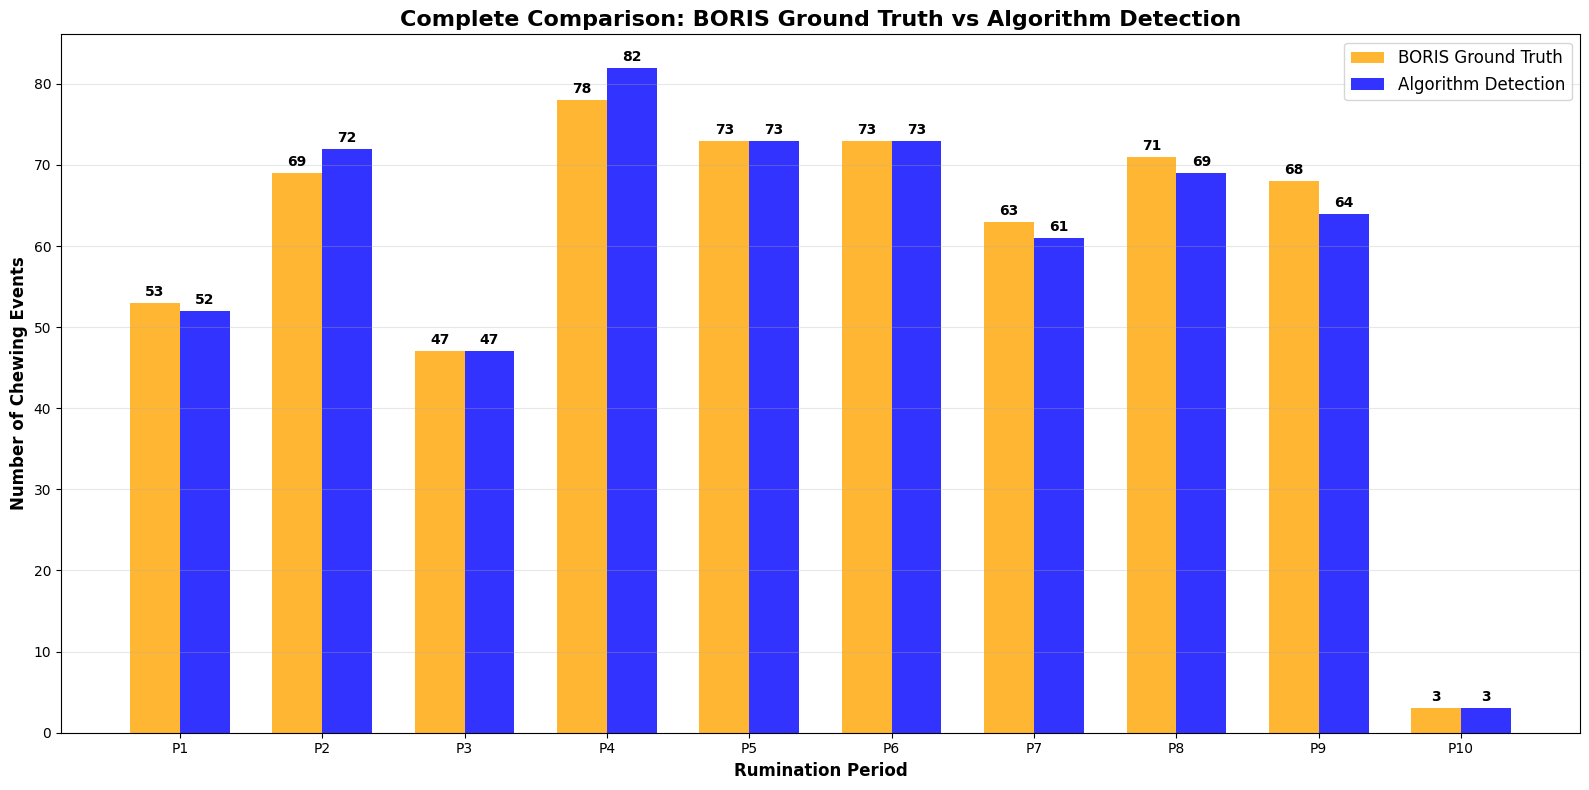

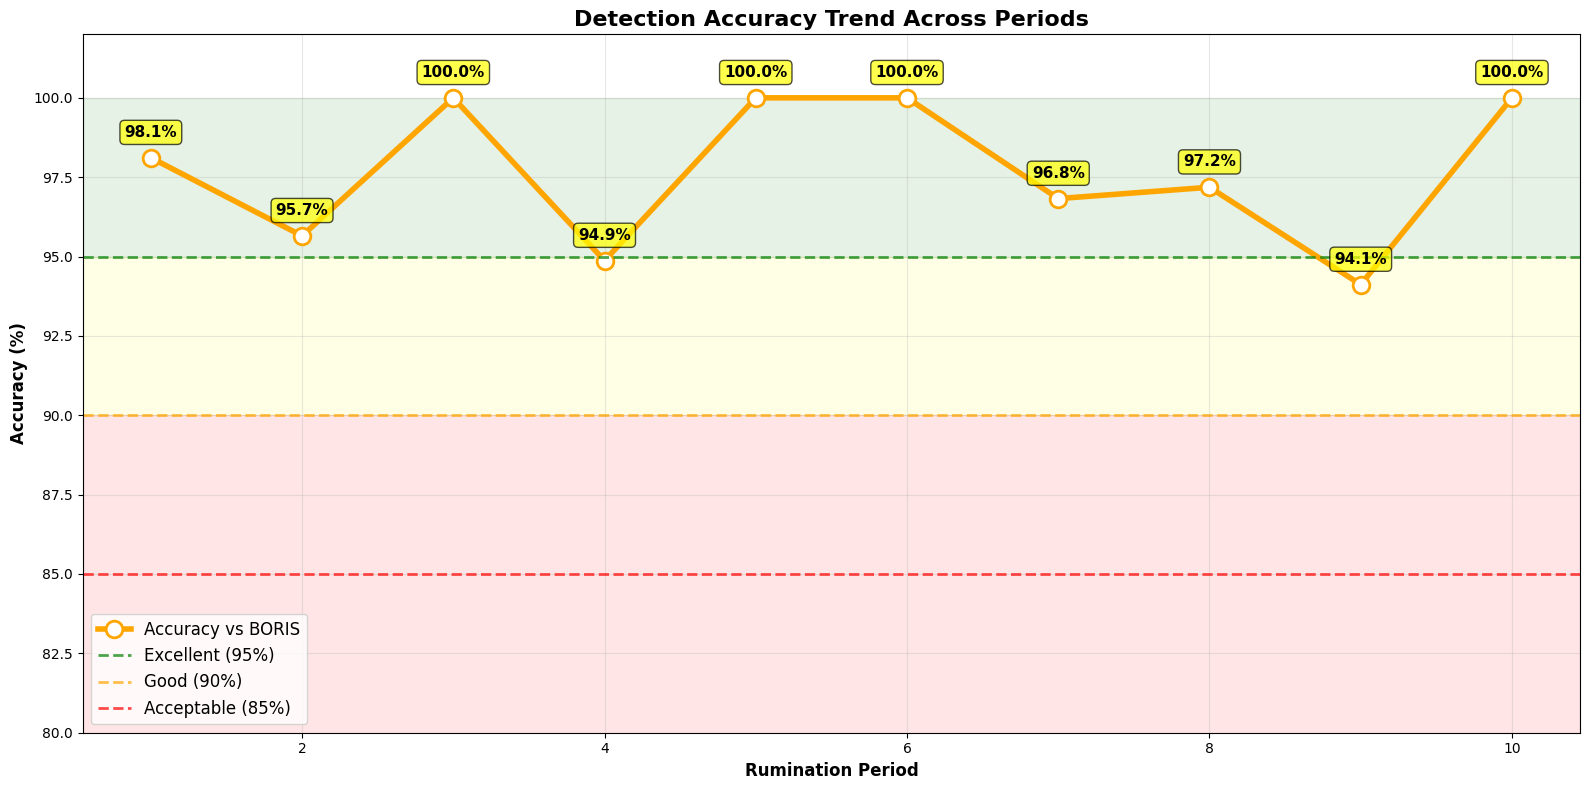

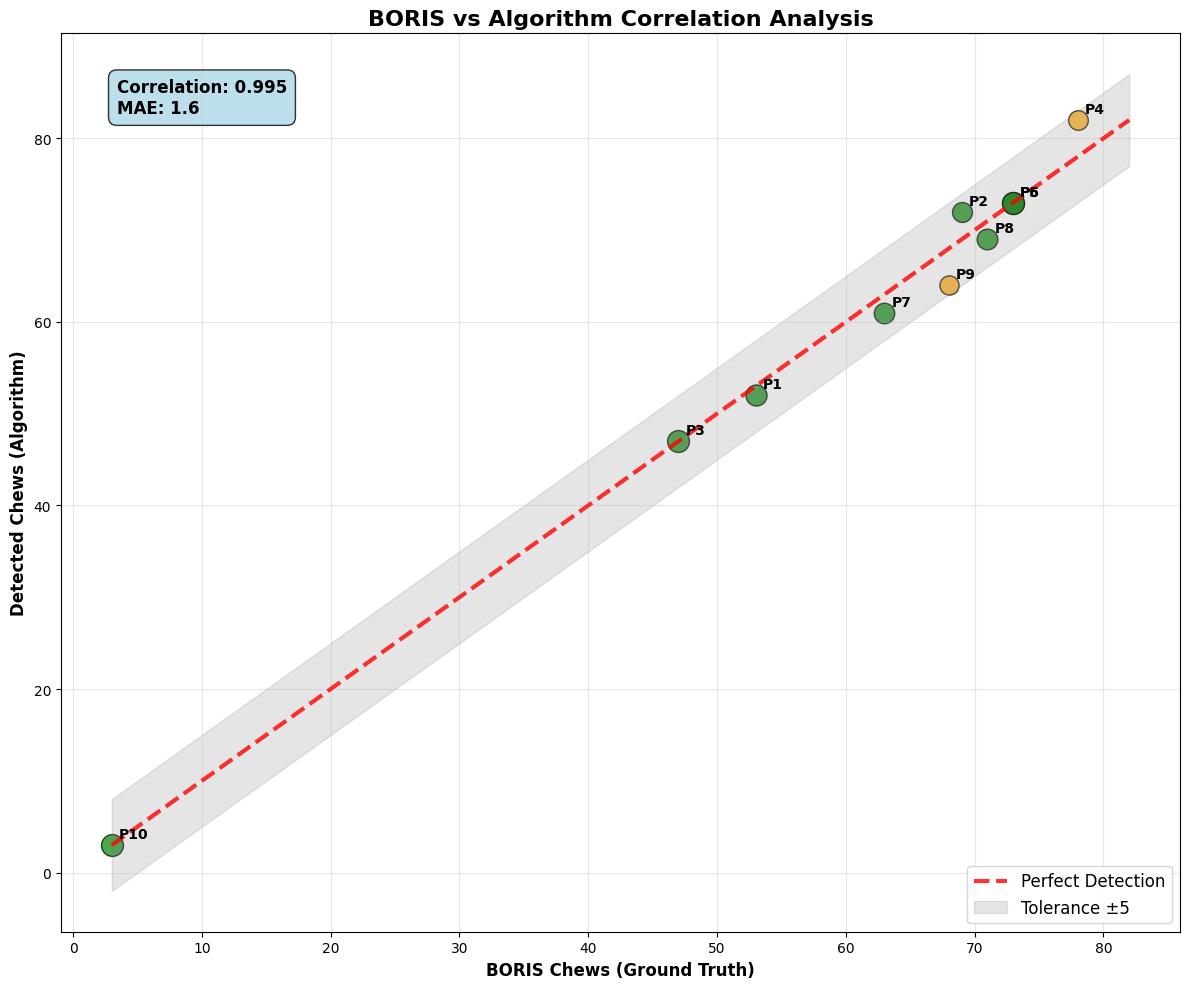

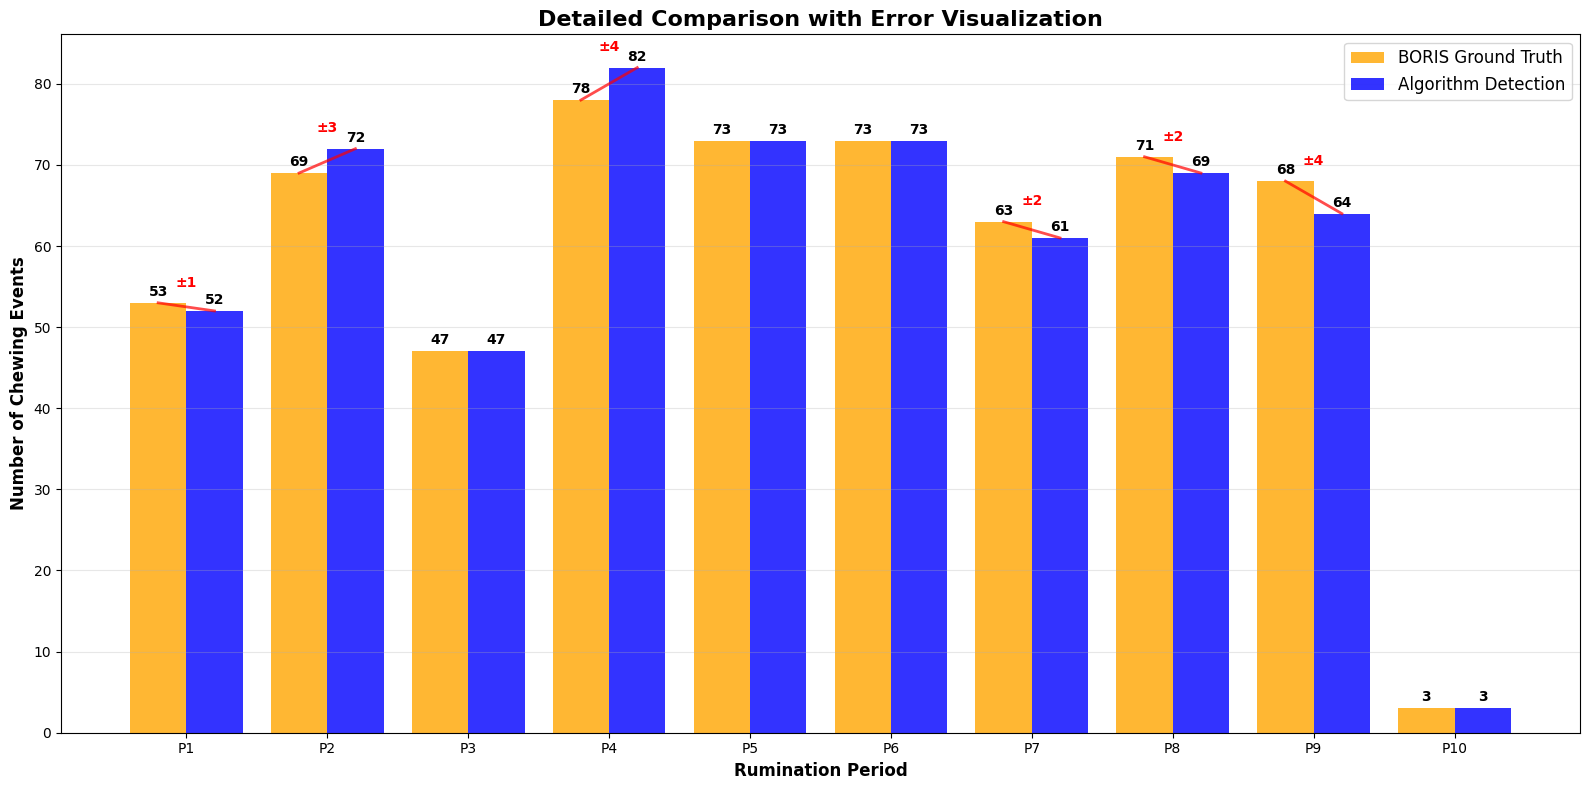

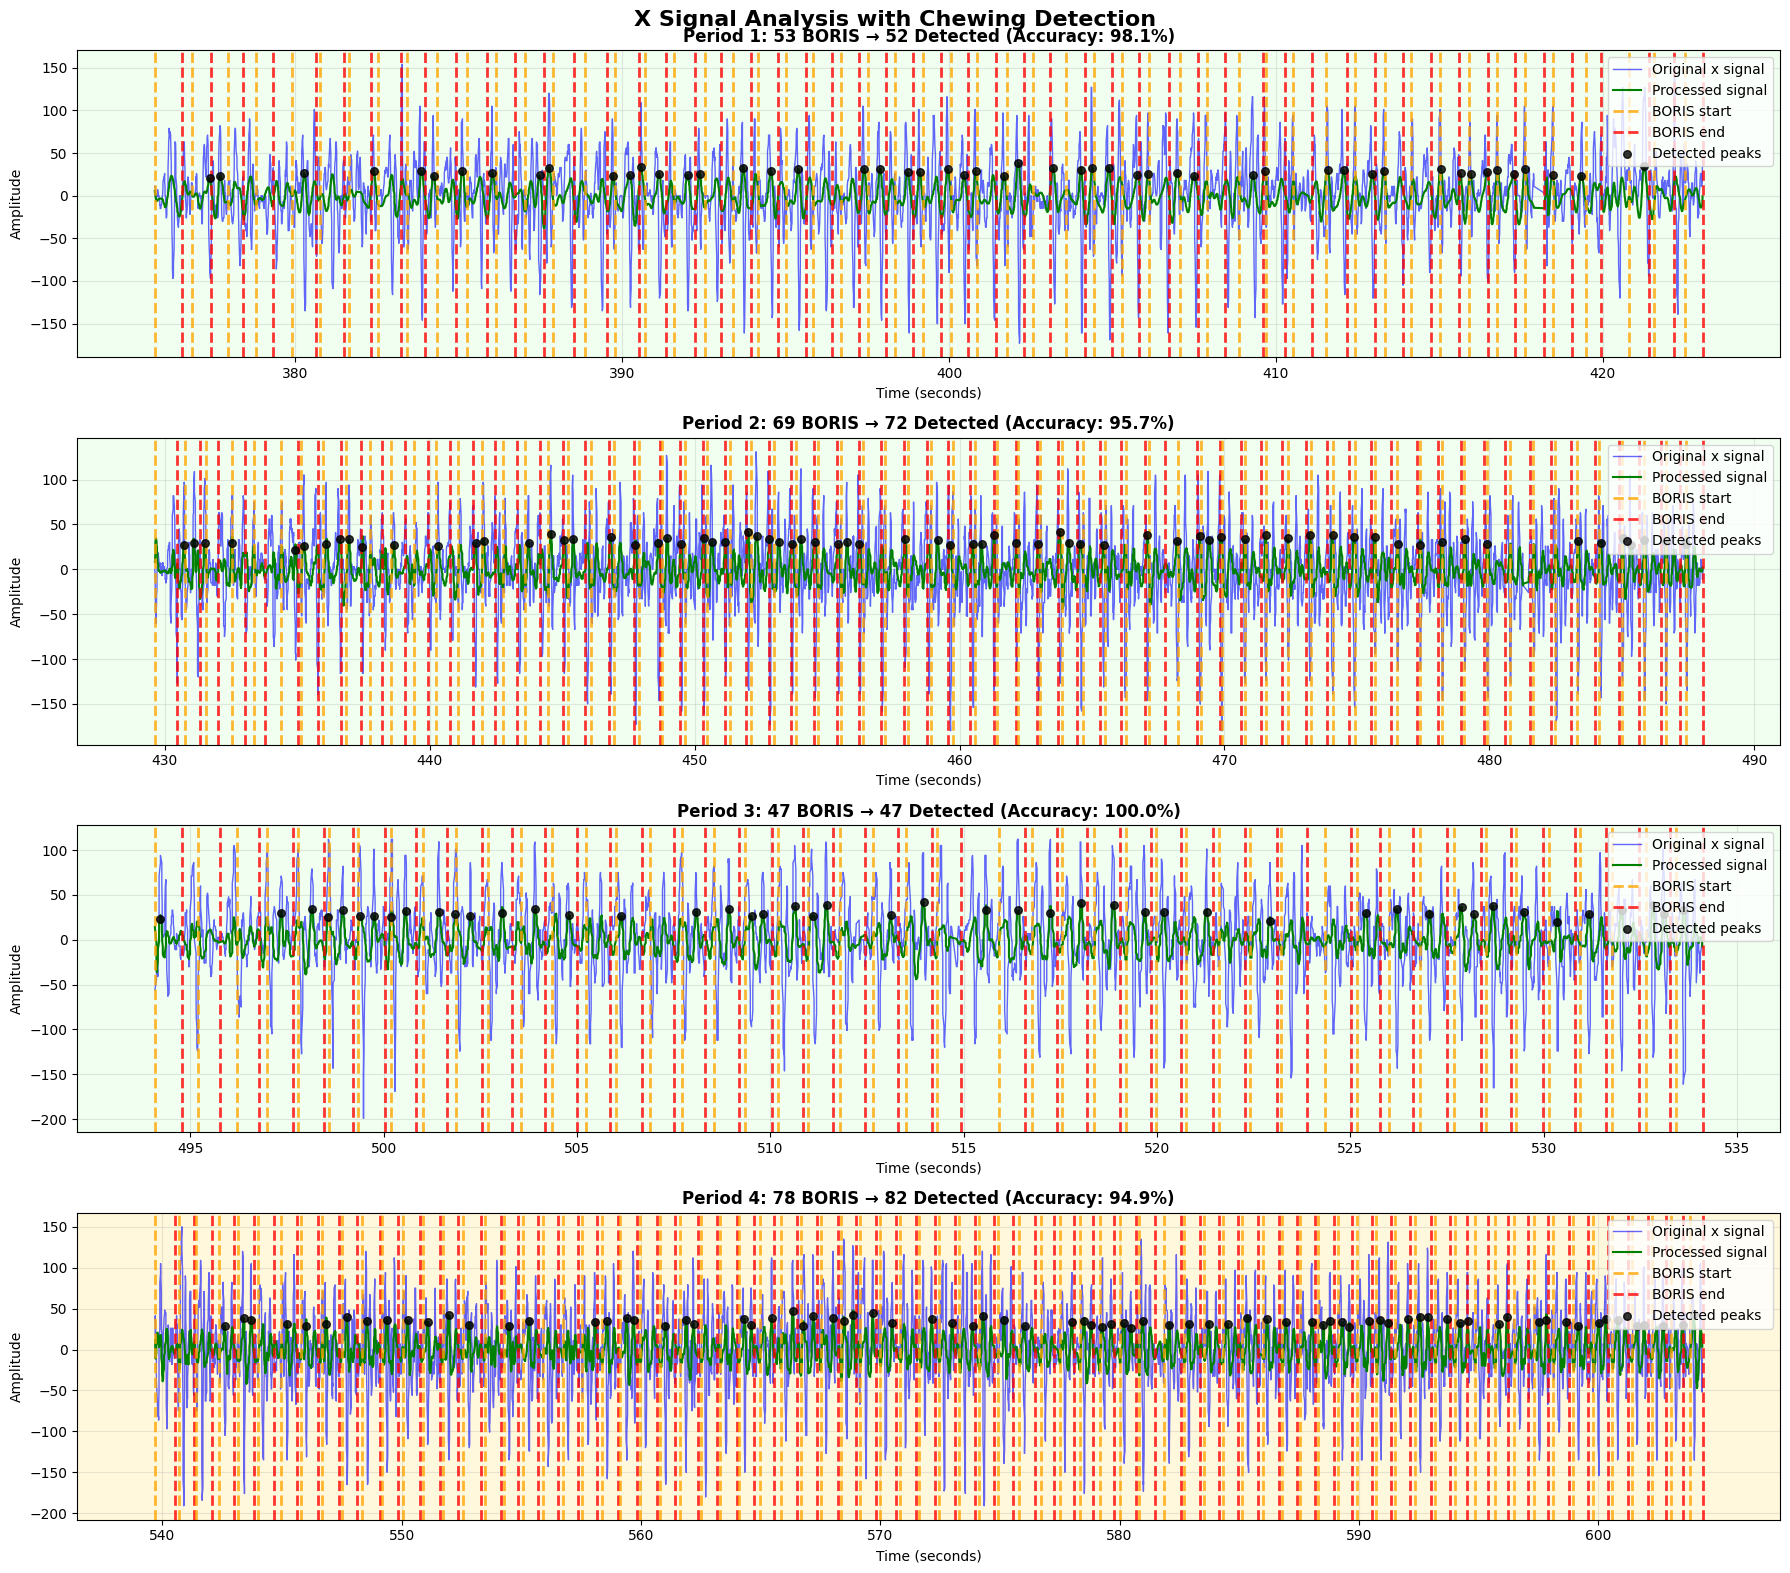


🎉 Chewing Detection System analysis completed!


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter
from dataclasses import dataclass
from typing import List, Tuple, Optional

# === CONFIGURATION PARAMETERS ===
@dataclass
class Config:
    """
    Configuration class for the chewing detection system.
    
    This system analyzes accelerometer data to detect chewing patterns during rumination periods,
    comparing automated detection with manual BORIS video annotations.
    
    Key Components:
    - Accelerometer Signal: X-axis acceleration data from a sensor worn by the animal
    - BORIS Annotations: Manual chewing event annotations from video analysis
    - Rumination Periods: Continuous sequences of chewing separated by gaps
    - Peak Detection: Algorithm to identify chewing events in the accelerometer signal
    """
    
    # File paths
    accel_csv_path: str = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_processed.csv"
    boris_csv_path: str = r"C:\Users\eleut\OneDrive\Desktop\boris_video3.csv"
    
    # Timing parameters (seconds)
    video_start_accel: float = 349.75  # Video start time in accelerometer timeline (374.75 - 25)
    first_major_chew_video: float = 25.0  # First significant chewing event in video timeline
    
    # Signal processing parameters - Optimized configuration
    gap_threshold: float = 2.0  # Minimum gap (seconds) between rumination periods
    outlier_factor: float = 1.7  # IQR multiplier for outlier removal
    
    # Bandpass filter parameters (Hz)
    bandpass_narrow: Tuple[float, float] = (1.3, 3.3)  # Tight filter for high-activity periods
    bandpass_wide: Tuple[float, float] = (0.9, 4.7)    # Wide filter for normal periods
    
    # Peak detection parameters
    height_factor: float = 0.25      # Height threshold multiplier (relative to signal std)
    prominence_factor: float = 0.18  # Peak prominence multiplier
    min_distance_factor: float = 0.35 # Minimum distance between peaks (relative to sampling rate)
    percentile_threshold: float = 78  # Percentile for high-activity detection
    
    # Visualization parameters
    signal_to_plot: str = "x"  # Signal column to analyze ("x" for x-axis acceleration)
    periods_to_show: List[int] = None  # Rumination periods to display (None = all)

class ChewingDetectionSystem:
    """
    Main class for chewing detection and analysis.
    
    The system processes accelerometer data to automatically detect chewing events
    and compares results with manual video annotations (BORIS) to evaluate performance.
    
    Signal Processing Pipeline:
    1. Load and synchronize accelerometer and BORIS data
    2. Identify rumination periods based on chewing gaps
    3. Apply adaptive filtering and outlier removal
    4. Detect peaks using enhanced algorithm
    5. Compare with BORIS annotations and calculate accuracy
    """
    
    def __init__(self, config: Config):
        self.config = config
        self.results_by_period = []
        self.df_accel = None
        self.boris_chews_p2 = []
        self.rumination_periods = []
        
    def calculate_sampling_rate(self, time_series):
        """
        Calculate sampling rate from time series.
        
        Args:
            time_series: Array of timestamp values
            
        Returns:
            Sampling rate in Hz, or None if cannot be calculated
        """
        if len(time_series) < 2:
            return None
        dt = np.diff(time_series)
        dt_clean = dt[dt > 0]
        return 1.0 / np.median(dt_clean) if len(dt_clean) > 0 else None

    def butter_filter_safe(self, data, cutoff, fs, ftype='low', order=4):
        """
        Apply Butterworth filter with error handling.
        
        Args:
            data: Input signal
            cutoff: Cutoff frequency (Hz) or tuple for bandpass
            fs: Sampling frequency (Hz)
            ftype: Filter type ('low', 'high', 'bandpass')
            order: Filter order
            
        Returns:
            Filtered signal or detrended signal if filtering fails
        """
        try:
            nyquist = 0.5 * fs
            if ftype == 'bandpass' and isinstance(cutoff, (list, tuple)) and len(cutoff) == 2:
                low, high = cutoff
                low_norm, high_norm = low / nyquist, high / nyquist
                if 0 < low_norm < high_norm < 1:
                    b, a = butter(order, [low_norm, high_norm], btype='band')
                    return filtfilt(b, a, data)
            else:
                normal_cutoff = cutoff / nyquist
                if 0 < normal_cutoff < 1:
                    b, a = butter(order, normal_cutoff, btype=ftype)
                    return filtfilt(b, a, data)
        except:
            pass
        return data - np.mean(data)  # Fallback to detrending

    def remove_outliers_iqr(self, signal):
        """
        Remove outliers using Interquartile Range (IQR) method.
        
        Args:
            signal: Input signal array
            
        Returns:
            Signal with outliers clipped to acceptable range
        """
        Q1, Q3 = np.percentile(signal, [25, 75])
        IQR = Q3 - Q1
        lower_bound = Q1 - self.config.outlier_factor * IQR
        upper_bound = Q3 + self.config.outlier_factor * IQR
        return np.clip(signal, lower_bound, upper_bound)

    def detect_chews_enhanced(self, time_segment, x_signal, sampling_rate):
        """
        Enhanced chewing detection algorithm with adaptive filtering.
        
        This method implements a sophisticated peak detection algorithm that:
        1. Removes outliers and applies absolute value transformation
        2. Adapts filter parameters based on signal variance
        3. Uses Savitzky-Golay smoothing for noise reduction
        4. Applies multi-criteria peak detection with quality scoring
        
        Args:
            time_segment: Time array for the signal segment
            x_signal: Accelerometer x-axis signal
            sampling_rate: Signal sampling rate in Hz
            
        Returns:
            Tuple of (detected_count, peak_times, processed_signal)
        """
        if len(x_signal) < 20 or sampling_rate is None or sampling_rate <= 0:
            return 0, [], x_signal
        
        # Step 1: Preprocessing - outlier removal and absolute value
        signal_clean = self.remove_outliers_iqr(np.abs(x_signal))
        
        # Step 2: Adaptive filter selection based on signal variance
        signal_variance = np.var(signal_clean)
        window_size = int(sampling_rate)  # 1-second windows
        variance_windows = []
        
        # Calculate variance in sliding windows to assess signal activity
        if len(x_signal) >= window_size:
            for i in range(0, len(x_signal) - window_size + 1, int(sampling_rate//2)):
                window_data = x_signal[i:i+window_size]
                if len(window_data) == window_size:
                    variance_windows.append(np.var(window_data))
        
        # Use narrow filter for high-activity periods, wide filter otherwise
        use_narrow_filter = (len(variance_windows) >= 3 and 
                           signal_variance > np.percentile(variance_windows, 75))
        
        # Step 3: Apply adaptive bandpass filtering
        cutoff = self.config.bandpass_narrow if use_narrow_filter else self.config.bandpass_wide
        signal_filtered = self.butter_filter_safe(signal_clean, cutoff, sampling_rate, 'bandpass', order=4)
        
        # Step 4: Savitzky-Golay smoothing for noise reduction
        window_len = min(max(int(0.40 * sampling_rate), 5), len(signal_filtered)//3)
        if window_len > 3 and len(signal_filtered) > window_len:
            if window_len % 2 == 0:
                window_len += 1
            poly_order = min(3, window_len//2)
            signal_smooth = savgol_filter(signal_filtered, window_len, poly_order)
        else:
            signal_smooth = signal_filtered
        
        # Step 5: Calculate detection thresholds
        signal_std = np.std(signal_smooth)
        signal_median = np.median(np.abs(signal_smooth))
        
        if signal_std == 0:
            return 0, [], signal_smooth
        
        # Multi-level threshold calculation
        high_activity_threshold = np.percentile(signal_smooth, self.config.percentile_threshold)
        height_threshold = max(
            self.config.height_factor * signal_std,
            0.8 * signal_median,
            0.3 * high_activity_threshold
        )
        prominence_threshold = self.config.prominence_factor * signal_std
        min_distance = max(int(self.config.min_distance_factor * sampling_rate), 4)
        
        # Step 6: Peak detection with quality constraints
        try:
            peaks_idx, properties = find_peaks(
                signal_smooth,
                height=height_threshold,
                prominence=prominence_threshold,
                distance=min_distance,
                width=(2, int(0.8*sampling_rate))
            )
        except:
            return 0, [], signal_smooth
        
        # Step 7: Quality-based peak filtering
        if len(peaks_idx) > 0:
            prominences = properties['prominences']
            heights = signal_smooth[peaks_idx]
            
            max_prominence = np.max(prominences)
            max_height = np.max(heights)
            
            if max_prominence > 0 and max_height > 0:
                # Normalize and combine prominence and height scores
                norm_prominence = prominences / max_prominence
                norm_height = heights / max_height
                combined_score = 0.6 * norm_prominence + 0.4 * norm_height
                
                # Filter peaks based on quality score
                score_threshold = np.percentile(combined_score, 50) if len(combined_score) >= 2 else np.min(combined_score)
                quality_peaks = peaks_idx[combined_score >= score_threshold]
                valid_peaks = quality_peaks[quality_peaks < len(time_segment)]
                
                if len(valid_peaks) > 0:
                    return len(valid_peaks), time_segment[valid_peaks], signal_smooth
        
        return 0, [], signal_smooth

    def load_data(self):
        """
        Load accelerometer and BORIS annotation data.
        
        Returns:
            BORIS behavior data filtered for chewing events
        """
        print("📊 Loading data files...")
        
        # Load accelerometer data
        self.df_accel = pd.read_csv(self.config.accel_csv_path)
        if 'time_s' not in self.df_accel.columns:
            if 'time_ms' in self.df_accel.columns:
                self.df_accel['time_s'] = self.df_accel['time_ms'] / 1000.0
            else:
                raise ValueError("Missing time_s or time_ms column in accelerometer data")
        
        # Load BORIS annotations
        df_boris = pd.read_csv(self.config.boris_csv_path)
        behavior_data = df_boris[df_boris['Behavior'].isin(['s', 'e'])].copy().sort_values('Time')
        
        return behavior_data

    def extract_boris_chews(self, behavior_data):
        """
        Extract chewing events from BORIS annotations.
        
        BORIS uses 's' (start) and 'e' (end) markers to define chewing periods.
        This method pairs these markers and converts video timestamps to 
        accelerometer timeline using the configured offset.
        
        Args:
            behavior_data: BORIS annotation data
        """
        period2_start_accel = self.config.video_start_accel + self.config.first_major_chew_video
        self.boris_chews_p2 = []
        
        i = 0
        while i < len(behavior_data) - 1:
            if (behavior_data.iloc[i]['Behavior'] == 's' and 
                behavior_data.iloc[i+1]['Behavior'] == 'e'):
                
                start_video = behavior_data.iloc[i]['Time']
                end_video = behavior_data.iloc[i+1]['Time']
                start_accel = self.config.video_start_accel + start_video
                
                # Only include chews after the first major chewing event
                if start_accel >= period2_start_accel:
                    self.boris_chews_p2.append({
                        'start_video': start_video,
                        'end_video': end_video,
                        'start_accel': start_accel,
                        'end_accel': self.config.video_start_accel + end_video,
                        'duration': end_video - start_video
                    })
                i += 2
            else:
                i += 1

    def identify_rumination_periods(self):
        """
        Identify rumination periods by detecting gaps between chewing events.
        
        A rumination period is a continuous sequence of chewing events.
        Periods are separated by gaps longer than the configured threshold.
        """
        if not self.boris_chews_p2:
            return
            
        # Find gaps between consecutive chewing events
        rumination_gaps = []
        for i in range(len(self.boris_chews_p2) - 1):
            gap_duration = self.boris_chews_p2[i+1]['start_accel'] - self.boris_chews_p2[i]['end_accel']
            if gap_duration >= self.config.gap_threshold:
                rumination_gaps.append(self.boris_chews_p2[i]['end_accel'])
        
        # Create rumination periods
        self.rumination_periods = []
        start_period = self.boris_chews_p2[0]['start_accel']
        
        for gap_time in rumination_gaps:
            self.rumination_periods.append((start_period, gap_time))
            # Find next period start
            for chew in self.boris_chews_p2:
                if chew['start_accel'] > gap_time:
                    start_period = chew['start_accel']
                    break
        
        # Add final period
        if self.boris_chews_p2:
            self.rumination_periods.append((start_period, self.boris_chews_p2[-1]['end_accel']))

    def analyze_periods(self):
        """
        Analyze each rumination period by comparing BORIS annotations with 
        automated chewing detection from accelerometer data.
        """
        period2_start_accel = self.config.video_start_accel + self.config.first_major_chew_video
        time = self.df_accel['time_s'].values
        x_signal = self.df_accel['x'].values
        
        # Focus on period 2 (post first major chew)
        mask_period2 = (time >= period2_start_accel) & (time <= time.max())
        time_period2 = time[mask_period2]
        x_period2 = x_signal[mask_period2]
        
        self.results_by_period = []
        
        for i, (rumination_start, rumination_end) in enumerate(self.rumination_periods):
            period_duration = rumination_end - rumination_start
            
            # Count BORIS chewing events in this period
            boris_count = sum(1 for chew in self.boris_chews_p2 
                            if rumination_start <= chew['start_accel'] <= rumination_end)
            
            # Detect chews using accelerometer data
            mask_rumination = (time_period2 >= rumination_start) & (time_period2 <= rumination_end)
            time_rumination = time_period2[mask_rumination]
            x_rumination = x_period2[mask_rumination]
            
            detected_count = 0
            detected_times = []
            processed_signal = []
            
            if len(time_rumination) > 20:
                sampling_rate = self.calculate_sampling_rate(time_rumination)
                if sampling_rate and sampling_rate > 0:
                    detected_count, detected_times, processed_signal = self.detect_chews_enhanced(
                        time_rumination, x_rumination, sampling_rate)
            
            # Calculate accuracy relative to BORIS ground truth
            boris_accuracy = (1 - abs(detected_count - boris_count) / max(boris_count, 1)) * 100 if boris_count > 0 else 0
            
            self.results_by_period.append({
                'period': i + 1,
                'start_accel': rumination_start,
                'end_accel': rumination_end,
                'duration': period_duration,
                'boris_count': boris_count,
                'detected_count': detected_count,
                'boris_accuracy': boris_accuracy,
                'time_segment': time_rumination,
                'signal_segment': x_rumination,
                'processed_signal': processed_signal,
                'detected_times': detected_times
            })

    def plot_signal_analysis(self, periods_to_show=None):
        """
        Visualize signal analysis with detected peaks and BORIS annotations.
        
        Shows the original accelerometer signal, processed signal, detected peaks,
        and BORIS chewing event markers for comparison.
        """
        if periods_to_show is None:
            periods_to_show = [1, 2, 3, 4]  # Show first 4 periods by default
        
        n_periods = len(periods_to_show)
        fig, axes = plt.subplots(n_periods, 1, figsize=(18, 4*n_periods))
        if n_periods == 1:
            axes = [axes]
        
        signal_column = self.config.signal_to_plot
        signal_data = self.df_accel[signal_column].values if signal_column in self.df_accel.columns else self.df_accel['x'].values
        
        fig.suptitle(f'{signal_column.upper()} Signal Analysis with Chewing Detection', 
                     fontsize=16, fontweight='bold')
        
        for idx, period_num in enumerate(periods_to_show):
            if period_num > len(self.results_by_period):
                continue
                
            result = self.results_by_period[period_num - 1]
            ax = axes[idx]
            
            # Get signal for this period
            time_all = self.df_accel['time_s'].values
            mask_period = (time_all >= result['start_accel']) & (time_all <= result['end_accel'])
            time_period = time_all[mask_period]
            signal_period = signal_data[mask_period]
            
            # Plot original signal
            ax.plot(time_period, signal_period, 'b-', alpha=0.6, linewidth=1, 
                   label=f'Original {signal_column} signal')
            
            # Plot processed signal if available
            if len(result['processed_signal']) > 0:
                ax.plot(result['time_segment'], result['processed_signal'], 'g-', 
                       linewidth=1.5, label='Processed signal')
            
            # Mark BORIS chewing events (start and end markers)
            boris_chews_in_period = [chew for chew in self.boris_chews_p2 
                                   if result['start_accel'] <= chew['start_accel'] <= result['end_accel']]
            
            for chew in boris_chews_in_period:
                ax.axvline(chew['start_accel'], color='orange', linestyle='--', alpha=0.8, 
                          linewidth=2, label='BORIS start' if chew == boris_chews_in_period[0] else "")
                ax.axvline(chew['end_accel'], color='red', linestyle='--', alpha=0.8, 
                          linewidth=2, label='BORIS end' if chew == boris_chews_in_period[0] else "")
            
            # Mark detected peaks with small black dots
            if len(result['detected_times']) > 0:
                # Find signal values at detected times
                detected_values = []
                for t in result['detected_times']:
                    idx_closest = np.argmin(np.abs(result['time_segment'] - t))
                    if len(result['processed_signal']) > idx_closest:
                        detected_values.append(result['processed_signal'][idx_closest])
                    else:
                        detected_values.append(0)
                
                ax.scatter(result['detected_times'], detected_values, 
                          color='black', s=30, marker='o', alpha=0.8, 
                          label='Detected peaks', zorder=5)
            
            # Customize plot
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Amplitude')
            ax.set_title(f'Period {period_num}: {result["boris_count"]} BORIS → {result["detected_count"]} Detected '
                        f'(Accuracy: {result["boris_accuracy"]:.1f}%)', fontweight='bold')
            ax.legend(loc='upper right')
            ax.grid(True, alpha=0.3)
            
            # Background color based on accuracy
            if result["boris_accuracy"] >= 95:
                ax.set_facecolor('#f0fff0')  # Light green - excellent
            elif result["boris_accuracy"] >= 90:
                ax.set_facecolor('#fff8dc')  # Light beige - good
            else:
                ax.set_facecolor('#ffe4e1')  # Light pink - needs improvement
        
        plt.tight_layout()
        plt.show()

    def plot_performance_charts(self):
        """
        Generate comprehensive performance visualization charts.
        
        Creates four different charts to analyze detection performance:
        1. Complete comparison bar chart
        2. Accuracy trend over periods
        3. BORIS vs Detected correlation scatter plot
        4. Detailed comparison with error visualization
        """
        periods = [r['period'] for r in self.results_by_period]
        boris_counts = [r['boris_count'] for r in self.results_by_period]
        detected_counts = [r['detected_count'] for r in self.results_by_period]
        boris_accuracies = [r['boris_accuracy'] for r in self.results_by_period]
        
        # === CHART 1: Complete Comparison ===
        plt.figure(figsize=(16, 8))
        x_pos = np.arange(len(periods))
        width = 0.35
        
        bars1 = plt.bar(x_pos - width/2, boris_counts, width, label='BORIS Ground Truth', alpha=0.8, color='orange')
        bars2 = plt.bar(x_pos + width/2, detected_counts, width, label='Algorithm Detection', alpha=0.8, color='blue')
        
        # Add values on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.xlabel('Rumination Period', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Chewing Events', fontsize=12, fontweight='bold')
        plt.title('Complete Comparison: BORIS Ground Truth vs Algorithm Detection', fontsize=16, fontweight='bold')
        plt.xticks(x_pos, [f'P{p}' for p in periods])
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # === CHART 2: Accuracy Trend ===
        plt.figure(figsize=(16, 8))
        plt.plot(periods, boris_accuracies, 'o-', color='orange', linewidth=4, markersize=12, 
                label='Accuracy vs BORIS', markerfacecolor='white', markeredgewidth=2)
        
        # Reference lines
        plt.axhline(y=95, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Excellent (95%)')
        plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Good (90%)')
        plt.axhline(y=85, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Acceptable (85%)')
        
        # Annotations on points
        for i, acc in enumerate(boris_accuracies):
            plt.annotate(f'{acc:.1f}%', (periods[i], acc), 
                        textcoords="offset points", xytext=(0,15), ha='center', 
                        fontsize=11, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
        
        # Background zones
        plt.axhspan(95, 100, alpha=0.1, color='green', label='_nolegend_')
        plt.axhspan(90, 95, alpha=0.1, color='yellow', label='_nolegend_')
        plt.axhspan(0, 90, alpha=0.1, color='red', label='_nolegend_')
        
        plt.xlabel('Rumination Period', fontsize=12, fontweight='bold')
        plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        plt.title('Detection Accuracy Trend Across Periods', fontsize=16, fontweight='bold')
        plt.ylim(80, 102)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # === CHART 3: BORIS vs Detected Correlation ===
        plt.figure(figsize=(12, 10))
        
        # Scatter with colors based on accuracy
        colors = ['green' if acc >= 95 else 'orange' if acc >= 90 else 'red' for acc in boris_accuracies]
        sizes = [100 + (acc-85)*10 for acc in boris_accuracies]  # Size based on accuracy
        
        for i, (boris, detected, color, size) in enumerate(zip(boris_counts, detected_counts, colors, sizes)):
            plt.scatter(boris, detected, c=color, s=size, alpha=0.7, edgecolors='black', linewidth=1)
            plt.annotate(f'P{periods[i]}', (boris, detected), 
                        textcoords="offset points", xytext=(5,5), ha='left', 
                        fontsize=10, fontweight='bold')
        
        # Perfect detection line
        max_chew = max(max(boris_counts), max(detected_counts))
        min_chew = min(min(boris_counts), min(detected_counts))
        plt.plot([min_chew, max_chew], [min_chew, max_chew], 'r--', 
                linewidth=3, alpha=0.8, label='Perfect Detection')
        
        # Tolerance bands
        tolerance = 5
        plt.fill_between([min_chew, max_chew], 
                        [min_chew-tolerance, max_chew-tolerance],
                        [min_chew+tolerance, max_chew+tolerance],
                        alpha=0.2, color='gray', label=f'Tolerance ±{tolerance}')
        
        plt.xlabel('BORIS Chews (Ground Truth)', fontsize=12, fontweight='bold')
        plt.ylabel('Detected Chews (Algorithm)', fontsize=12, fontweight='bold')
        plt.title('BORIS vs Algorithm Correlation Analysis', fontsize=16, fontweight='bold')
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add statistics
        correlation = np.corrcoef(boris_counts, detected_counts)[0,1]
        mae = np.mean([abs(b-d) for b,d in zip(boris_counts, detected_counts)])
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}\nMAE: {mae:.1f}', 
                transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
                verticalalignment='top')
        
        plt.tight_layout()
        plt.show()
        
        # === CHART 4: Detailed Comparison with Errors ===
        plt.figure(figsize=(16, 8))
        
        x_pos = np.arange(len(periods))
        errors = [abs(b-d) for b,d in zip(boris_counts, detected_counts)]
        
        bars1 = plt.bar(x_pos - 0.2, boris_counts, 0.4, label='BORIS Ground Truth', alpha=0.8, color='orange')
        bars2 = plt.bar(x_pos + 0.2, detected_counts, 0.4, label='Algorithm Detection', alpha=0.8, color='blue')
        
        # Error lines
        for i, error in enumerate(errors):
            if error > 0:
                plt.plot([i-0.2, i+0.2], [boris_counts[i], detected_counts[i]], 
                        'r-', linewidth=2, alpha=0.7)
                plt.text(i, max(boris_counts[i], detected_counts[i]) + 2, 
                        f'±{error}', ha='center', fontweight='bold', color='red')
        
        # Values on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.xlabel('Rumination Period', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Chewing Events', fontsize=12, fontweight='bold')
        plt.title('Detailed Comparison with Error Visualization', fontsize=16, fontweight='bold')
        plt.xticks(x_pos, [f'P{p}' for p in periods])
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

    def print_summary(self):
        """
        Print comprehensive analysis summary with key performance metrics.
        """
        total_boris = sum(r['boris_count'] for r in self.results_by_period)
        total_detected = sum(r['detected_count'] for r in self.results_by_period)
        avg_boris_accuracy = np.mean([r['boris_accuracy'] for r in self.results_by_period])
        
        print(f"\n🎯 COMPREHENSIVE ANALYSIS RESULTS:")
        print(f"   Rumination periods identified: {len(self.results_by_period)}")
        print(f"   Total chewing events - BORIS: {total_boris}, Detected: {total_detected}")
        print(f"   Average accuracy vs BORIS: {avg_boris_accuracy:.1f}%")
        print(f"   Signal analyzed: {self.config.signal_to_plot}")
        print(f"   Detection algorithm: Enhanced multi-criteria peak detection")
        
        return avg_boris_accuracy

    def run_complete_analysis(self):
        """
        Execute the complete chewing detection analysis pipeline.
        
        Returns:
            Average detection accuracy
        """
        behavior_data = self.load_data()
        self.extract_boris_chews(behavior_data)
        self.identify_rumination_periods()
        print(f"🔍 Identified {len(self.rumination_periods)} rumination periods")
        self.analyze_periods()
        return self.print_summary()


def parameter_optimization_test():
    """
    Advanced parameter testing system to find optimal detection settings.
    
    This function tests multiple parameter combinations focusing on:
    - Gap thresholds for period separation
    - Height factors for peak detection
    - Outlier removal sensitivity
    - Filter parameters
    """
    print("🧪 ADVANCED PARAMETER OPTIMIZATION")
    print("="*80)
    
    # Parameter ranges to test
    gap_values = [1.5, 2.0, 2.5, 3.0]
    height_values = [0.2, 0.25, 0.3, 0.35, 0.4]
    outlier_values = [1.0, 1.7, 2.0, 2.5]
    prominence_values = [0.15, 0.18, 0.25, 0.3]
    
    optimization_results = []
    
    print(f"Testing {len(gap_values) * len(height_values) * len(outlier_values)} parameter combinations...")
    
    for gap in gap_values:
        for height in height_values:
            for outlier in outlier_values[:2]:  # Limit for computational efficiency
                for prominence in prominence_values[:2]:
                    config = Config(
                        gap_threshold=gap,
                        height_factor=height,
                        outlier_factor=outlier,
                        prominence_factor=prominence,
                        signal_to_plot="x"
                    )
                    
                    try:
                        system = ChewingDetectionSystem(config)
                        accuracy = system.run_complete_analysis()
                        
                        optimization_results.append({
                            'config_name': f"Gap:{gap}, H:{height}, Out:{outlier}, Prom:{prominence}",
                            'accuracy': accuracy,
                            'gap': gap,
                            'height': height,
                            'outlier': outlier,
                            'prominence': prominence,
                            'config_obj': config
                        })
                    except Exception as e:
                        print(f"Error with config Gap:{gap}, H:{height}, Out:{outlier}, Prom:{prominence}: {e}")
                        continue
    
    # Sort by accuracy
    optimization_results.sort(key=lambda x: x['accuracy'], reverse=True)
    
    print(f"\n🏆 TOP 15 OPTIMIZED CONFIGURATIONS:")
    print(f"{'Rank':<5} {'Configuration':<45} {'Accuracy':<12}")
    print("-" * 70)
    
    for i, result in enumerate(optimization_results[:15]):
        print(f"{i+1:<5} {result['config_name']:<45} {result['accuracy']:<11.1f}%")
    
    return optimization_results[:5]  # Return top 5 configurations


def signal_comparison_analysis():
    """
    Compare different signal processing approaches and configurations.
    
    Tests the performance difference between:
    - X-axis signal vs normalized moving average
    - Different filter configurations
    - Various preprocessing approaches
    """
    print(f"\n🔬 SIGNAL PROCESSING COMPARISON ANALYSIS:")
    print("="*60)
    
    # Use optimized parameters from configuration
    base_config_params = {
        'gap_threshold': 2.0,
        'height_factor': 0.25,
        'outlier_factor': 1.7,
        'prominence_factor': 0.18
    }
    
    signal_tests = [
        ("X-axis Signal", {"signal_to_plot": "x", **base_config_params}),
        ("Norm MovAvg", {"signal_to_plot": "norm_mavg", **base_config_params}),
    ]
    
    comparison_results = []
    
    for signal_name, config_params in signal_tests:
        print(f"Testing {signal_name}...")
        config = Config(**config_params)
        
        try:
            system = ChewingDetectionSystem(config)
            accuracy = system.run_complete_analysis()
            
            comparison_results.append({
                'signal_type': signal_name,
                'accuracy': accuracy,
                'config': config,
                'system': system
            })
        except Exception as e:
            print(f"Error testing {signal_name}: {e}")
            comparison_results.append({
                'signal_type': signal_name,
                'accuracy': 0.0,
                'config': config,
                'system': None
            })
    
    print(f"\n📊 SIGNAL COMPARISON RESULTS:")
    print(f"{'Signal Type':<15} {'Accuracy':<12} {'Status'}")
    print("-" * 40)
    
    for result in comparison_results:
        status = "✅ Success" if result['accuracy'] > 0 else "❌ Failed"
        print(f"{result['signal_type']:<15} {result['accuracy']:<11.1f}% {status}")
    
    # Find best performing signal
    best_signal = max(comparison_results, key=lambda x: x['accuracy'])
    print(f"\n🎯 OPTIMAL SIGNAL: {best_signal['signal_type']} ({best_signal['accuracy']:.1f}% accuracy)")
    
    return best_signal


def focused_period_analysis():
    """
    Detailed analysis focusing on challenging periods (typically 8 and 9).
    
    This function provides targeted parameter tuning for periods that 
    show lower detection accuracy.
    """
    print("⚡ FOCUSED ANALYSIS - Challenging Periods Optimization")
    print("="*65)
    
    # Specialized configurations for challenging periods
    focused_configs = [
        ("Default Optimized", {}),
        ("High Sensitivity", {"height_factor": 0.2, "prominence_factor": 0.15}),
        ("Permissive Outliers", {"outlier_factor": 2.5}),
        ("Tight Gap Detection", {"gap_threshold": 1.5}),
        ("Wide Filter Range", {"bandpass_wide": (0.7, 5.0)}),
        ("Ultra Sensitive", {"height_factor": 0.18, "prominence_factor": 0.12, "min_distance_factor": 0.25}),
        ("Robust Processing", {"outlier_factor": 2.0, "percentile_threshold": 75}),
        ("Fine-tuned Combined", {"height_factor": 0.22, "prominence_factor": 0.16, "outlier_factor": 2.2})
    ]
    
    focused_results = []
    
    for config_name, modifications in focused_configs:
        # Start with optimized base parameters
        config_params = {
            'gap_threshold': 2.0,
            'height_factor': 0.25,
            'outlier_factor': 1.7,
            'prominence_factor': 0.18,
            'signal_to_plot': "x"
        }
        config_params.update(modifications)  # Apply modifications
        
        config = Config(**config_params)
        system = ChewingDetectionSystem(config)
        
        try:
            overall_accuracy = system.run_complete_analysis()
            
            # Calculate accuracy for challenging periods (8 and 9)
            period_8_acc = system.results_by_period[7]['boris_accuracy'] if len(system.results_by_period) > 7 else 0
            period_9_acc = system.results_by_period[8]['boris_accuracy'] if len(system.results_by_period) > 8 else 0
            challenging_periods_avg = (period_8_acc + period_9_acc) / 2 if period_8_acc > 0 or period_9_acc > 0 else 0
            
            focused_results.append({
                'config_name': config_name,
                'overall_accuracy': overall_accuracy,
                'challenging_periods_avg': challenging_periods_avg,
                'period_8_accuracy': period_8_acc,
                'period_9_accuracy': period_9_acc,
                'config': config,
                'system': system
            })
        except Exception as e:
            print(f"Error with {config_name}: {e}")
            continue
    
    # Sort by challenging periods performance
    focused_results.sort(key=lambda x: x['challenging_periods_avg'], reverse=True)
    
    print(f"\n📊 FOCUSED ANALYSIS RESULTS:")
    print(f"{'Configuration':<20} {'Overall':<9} {'P8+P9 Avg':<10} {'Period 8':<9} {'Period 9':<9}")
    print("-" * 70)
    
    for result in focused_results:
        print(f"{result['config_name']:<20} {result['overall_accuracy']:<8.1f}% "
              f"{result['challenging_periods_avg']:<9.1f}% {result['period_8_accuracy']:<8.1f}% "
              f"{result['period_9_accuracy']:<8.1f}%")
    
    if focused_results:
        best_config = focused_results[0]
        print(f"\n🏆 BEST CONFIGURATION FOR CHALLENGING PERIODS: {best_config['config_name']}")
        print(f"   Challenging periods improvement: {best_config['challenging_periods_avg']:.1f}%")
        print(f"   Overall system accuracy: {best_config['overall_accuracy']:.1f}%")
        
        return best_config['system']
    
    return None


def comprehensive_analysis_pipeline():
    """
    Complete analysis pipeline with optimization and visualization.
    
    This function runs the full analysis including:
    1. Standard analysis with optimized parameters
    2. Parameter optimization testing
    3. Signal comparison
    4. Focused analysis on challenging periods
    5. Final visualization with best configuration
    """
    print("🚀 COMPREHENSIVE CHEWING DETECTION ANALYSIS PIPELINE")
    print("="*80)
    
    # Step 1: Standard analysis with optimized parameters
    print("\n📊 STEP 1: Standard Analysis with Optimized Parameters")
    config = Config(
        signal_to_plot="x",
        periods_to_show=[1, 2, 8, 9],  # Include challenging periods
        # Using optimized parameters from configuration
        gap_threshold=2.0,
        outlier_factor=1.7,
        bandpass_narrow=(1.3, 3.3),
        bandpass_wide=(0.9, 4.7),
        height_factor=0.25,
        prominence_factor=0.18,
        min_distance_factor=0.35,
        percentile_threshold=78
    )
    
    standard_system = ChewingDetectionSystem(config)
    standard_accuracy = standard_system.run_complete_analysis()
    
    print(f"\n📈 GENERATING PERFORMANCE VISUALIZATIONS...")
    standard_system.plot_performance_charts()
    standard_system.plot_signal_analysis()
    
    # Step 2: Parameter optimization (optional - computationally intensive)
    print(f"\n🧪 STEP 2: Parameter Optimization Testing")
    try:
        optimization_results = parameter_optimization_test()
        print(f"Parameter optimization completed successfully.")
    except Exception as e:
        print(f"Parameter optimization skipped due to: {e}")
        optimization_results = []
    
    # Step 3: Signal comparison analysis
    print(f"\n🔬 STEP 3: Signal Processing Comparison")
    best_signal_result = signal_comparison_analysis()
    
    # Step 4: Focused analysis on challenging periods
    print(f"\n⚡ STEP 4: Focused Analysis on Challenging Periods")
    focused_system = focused_period_analysis()
    
    # Step 5: Final analysis with best configuration
    if focused_system and focused_system.results_by_period:
        print(f"\n🎯 STEP 5: Final Analysis with Optimized Configuration")
        print(f"Generating final visualizations with best performing system...")
        focused_system.plot_performance_charts()
        focused_system.plot_signal_analysis([8, 9, 1, 2])  # Focus on critical periods
    
    # Final summary
    print(f"\n🏁 FINAL ANALYSIS SUMMARY:")
    print(f"   Standard analysis accuracy: {standard_accuracy:.1f}%")
    if best_signal_result:
        print(f"   Best signal type: {best_signal_result['signal_type']} ({best_signal_result['accuracy']:.1f}%)")
    if focused_system:
        focused_accuracy = np.mean([r['boris_accuracy'] for r in focused_system.results_by_period])
        print(f"   Optimized system accuracy: {focused_accuracy:.1f}%")
        print(f"   System improvement: {focused_accuracy - standard_accuracy:+.1f}%")
    
    print(f"\n✅ Analysis pipeline completed successfully!")
    
    return focused_system if focused_system else standard_system


# === MAIN EXECUTION MODES ===
def run_analysis_mode(mode="standard"):
    """
    Main execution function with different analysis modes.
    
    Args:
        mode: Analysis mode selection
            - "standard": Basic analysis with optimized parameters
            - "optimization": Parameter optimization testing
            - "comprehensive": Full analysis pipeline
            - "focused": Focused analysis on challenging periods
    """
    print("🎯 CHEWING DETECTION SYSTEM - ANALYSIS MODE SELECTION")
    print("="*65)
    
    if mode == "standard":
        print("📊 STANDARD ANALYSIS MODE")
        config = Config(signal_to_plot="x", periods_to_show=[1, 2, 8, 9])
        system = ChewingDetectionSystem(config)
        system.run_complete_analysis()
        system.plot_performance_charts()
        system.plot_signal_analysis()
        
    elif mode == "optimization":
        print("🧪 PARAMETER OPTIMIZATION MODE")
        optimization_results = parameter_optimization_test()
        if optimization_results:
            best_config = optimization_results[0]['config_obj']
            print(f"\n🔬 Testing optimal configuration:")
            system = ChewingDetectionSystem(best_config)
            system.run_complete_analysis()
            system.plot_performance_charts()
            system.plot_signal_analysis()
        
    elif mode == "focused":
        print("⚡ FOCUSED ANALYSIS MODE")
        focused_system = focused_period_analysis()
        if focused_system:
            focused_system.plot_performance_charts()
            focused_system.plot_signal_analysis()
            
    elif mode == "comprehensive":
        print("🚀 COMPREHENSIVE ANALYSIS MODE")
        comprehensive_analysis_pipeline()
        
    else:
        print(f"❌ Unknown mode: {mode}")
        print("Available modes: 'standard', 'optimization', 'focused', 'comprehensive'")


# === EXECUTION ENTRY POINT ===
if __name__ == "__main__":
    """
    Main execution entry point.
    
    The Chewing Detection System analyzes accelerometer data to automatically
    detect chewing events during rumination periods and compares the results
    with manual video annotations (BORIS) to evaluate algorithm performance.
    
    System Components:
    - Accelerometer Signal Processing: Filters and enhances x-axis acceleration data
    - Peak Detection Algorithm: Multi-criteria approach with adaptive thresholds
    - BORIS Integration: Synchronizes with manual video annotation timestamps
    - Performance Analysis: Comprehensive accuracy evaluation and visualization
    
    Usage:
    Change the 'analysis_mode' variable below to select different analysis types:
    - "standard": Quick analysis with optimized parameters
    - "optimization": Extensive parameter testing (computationally intensive)
    - "focused": Targeted analysis for challenging detection periods
    - "comprehensive": Complete pipeline with all analysis types
    """
    
    # SELECT ANALYSIS MODE HERE
    analysis_mode = "standard"  # Change this to: "optimization", "focused", or "comprehensive"
    
    try:
        run_analysis_mode(analysis_mode)
    except Exception as e:
        print(f"❌ Analysis failed with error: {e}")
        print(f"Please check your data files and configuration settings.")
        
    print(f"\n🎉 Chewing Detection System analysis completed!")